# I. Import Library

In [70]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from graphviz import Source

# II. Preparing the datasets

In [71]:
# Cấu hình đường dẫn và tham số
class Config:
    train_size = 0.8
    data_path = r'..\HeartDisease\cleveland.data'
    save_dir = r'..\HeartDisease\plots'
    
cfg = Config()

In [72]:
# Định nghĩa các cột trong dataset
columns = [
    'id', 'ccf', 'age', 'sex', 'painloc', 'painexer', 'relrest', 'pncaden', 'cp', 'trestbps', 
    'htn', 'chol', 'smoke', 'cigs', 'years', 'fbs', 'dm', 'famhist', 'restecg', 'ekgmo', 
    'ekgday', 'ekgyr', 'dig', 'prop', 'nitr', 'pro', 'diuretic', 'proto', 'thaldur', 'thaltime', 
    'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'exang', 'xhypo', 
    'oldpeak', 'slope', 'rldv5', 'rldv5e', 'ca', 'restckm', 'exerckm', 'restef', 'restwm', 
    'exeref', 'exerwm', 'thal', 'thalsev', 'thalpul', 'earlobe', 'cmo', 'cday', 'cyr', 'num', 
    'lmt', 'ladprox', 'laddist', 'diag', 'cxmain', 'ramus', 'om1', 'om2', 'rcaprox', 'rcadist', 
    'lvx1', 'lvx2', 'lvx3', 'lvx4', 'lvf', 'cathef', 'junk', 'name'
]


# Những cột được chọn trong quá trình huấuấn luyện và test
selected_columns = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'
]

In [73]:
# Hàm đọc và xử lý dataset ( Cái này chỉ cho dataset này thôi, các dataset còn lại không dùng)
def load_dataset(data_path, names, label_col, encoding='latin1'):
    records = []
    current_record = []
    with open(data_path, 'r', encoding=encoding, errors='replace') as file:
        for line in file:
            values = line.strip().split()
            current_record.extend(values)
            if values and values[-1] == 'name' and len(current_record) == 76:
                records.append(current_record)
                current_record = []
    
    data = pd.DataFrame(records, columns=names)[selected_columns]
    for col in selected_columns:
        if col != 'oldpeak':
            data[col] = data[col].astype('Int64')
            
    data['oldpeak'] = data['oldpeak'].astype('float64') 
    
    labels = data[label_col].apply(lambda x: 0 if x == 0 else 1)
    
    return data, labels

In [74]:
# Đọc và hiển thị thông tin dataset
df, labels = load_dataset(cfg.data_path, columns, 'num')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       282 non-null    Int64  
 1   sex       282 non-null    Int64  
 2   cp        282 non-null    Int64  
 3   trestbps  282 non-null    Int64  
 4   chol      282 non-null    Int64  
 5   fbs       282 non-null    Int64  
 6   restecg   282 non-null    Int64  
 7   thalach   282 non-null    Int64  
 8   exang     282 non-null    Int64  
 9   oldpeak   282 non-null    float64
 10  slope     282 non-null    Int64  
 11  ca        282 non-null    Int64  
 12  thal      282 non-null    Int64  
 13  num       282 non-null    Int64  
dtypes: Int64(13), float64(1)
memory usage: 34.6 KB
None


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca  thal  num  
0   0     6    0  
1   3     3    2  
2   2     7    1  
3   0     3    0  
4   0     3    0

Chỉ đọc được 282 / 303 samples vì dữ liệu bị mã hóa

# III. Data Analysis Functions

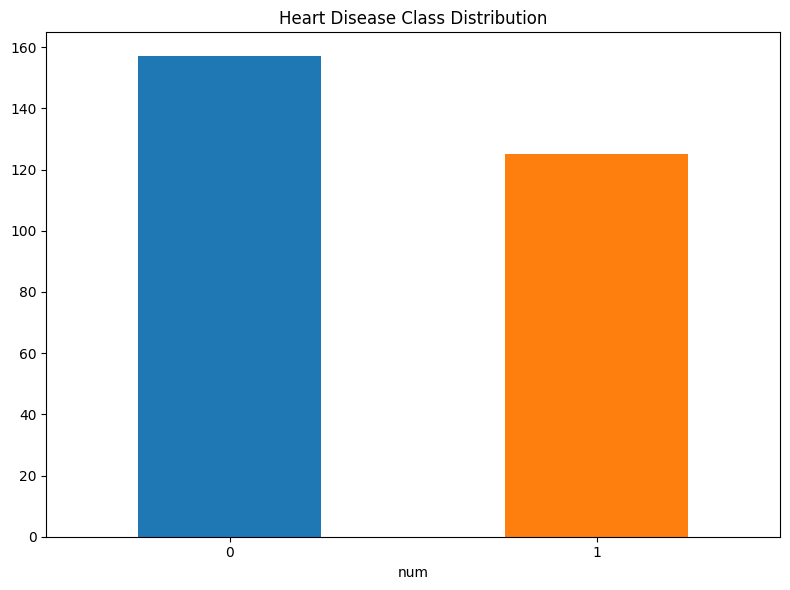

In [75]:
# Hàm vẽ biểu đồ phân phối lớp
def plot_class_distribution(labels, title="Heart Disease Class Distribution"):
    class_counts = labels.value_counts().sort_index()
    
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
    plt.title(title)
    plt.xticks(range(len(class_counts)), rotation=0)
    plt.tight_layout()
    
    plt.show()
    
plot_class_distribution(labels)

In [76]:
# Hàm chia và chuẩn hóa dữ liệu
def split_and_scale_data(X, y, proportions):
    X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns, index=X.index)
    
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    X_shuffled = X_scaled.iloc[indices]
    y_shuffled = y.iloc[indices]
    
    subsets = [
        {
            'train_size': p,
            'X_train': X_train,
            'y_train': y_train,
            'X_test': X_test,
            'y_test': y_test
        }
        for p in proportions
        for X_train, X_test, y_train, y_test in [train_test_split(
            X_shuffled, y_shuffled,
            train_size=p,
            stratify=y_shuffled,
            random_state=42
        )]
    ]
    
    return subsets, X_scaled

# IV. Split Dataset into Different Ratios

In [77]:
# Chuẩn bị dữ liệu cho thực nghiệm
X = df.drop(columns=['num'])
y = labels

proportions = [0.4, 0.6, 0.8, 0.9]

subset_data, X = split_and_scale_data(X, y, proportions)


## 1. Display the class distribution of subsets

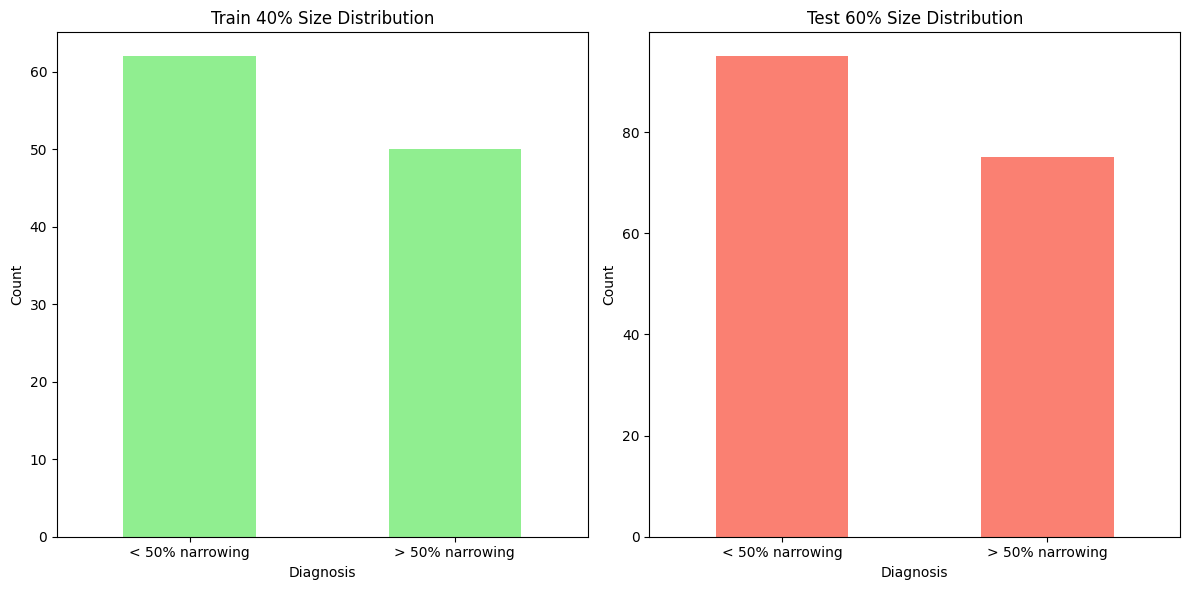

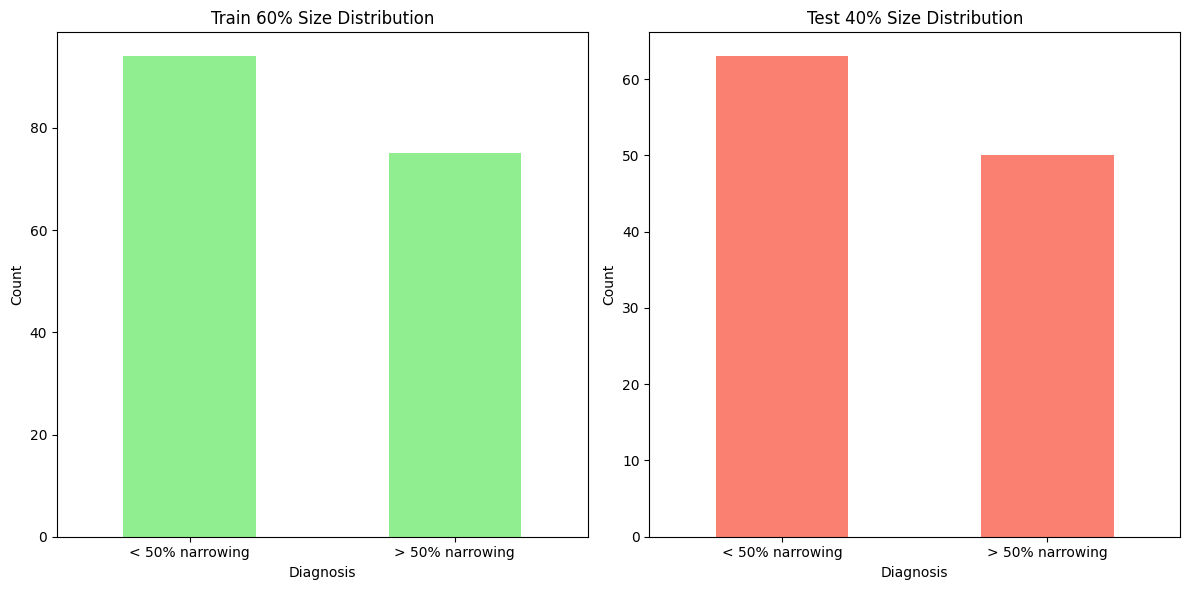

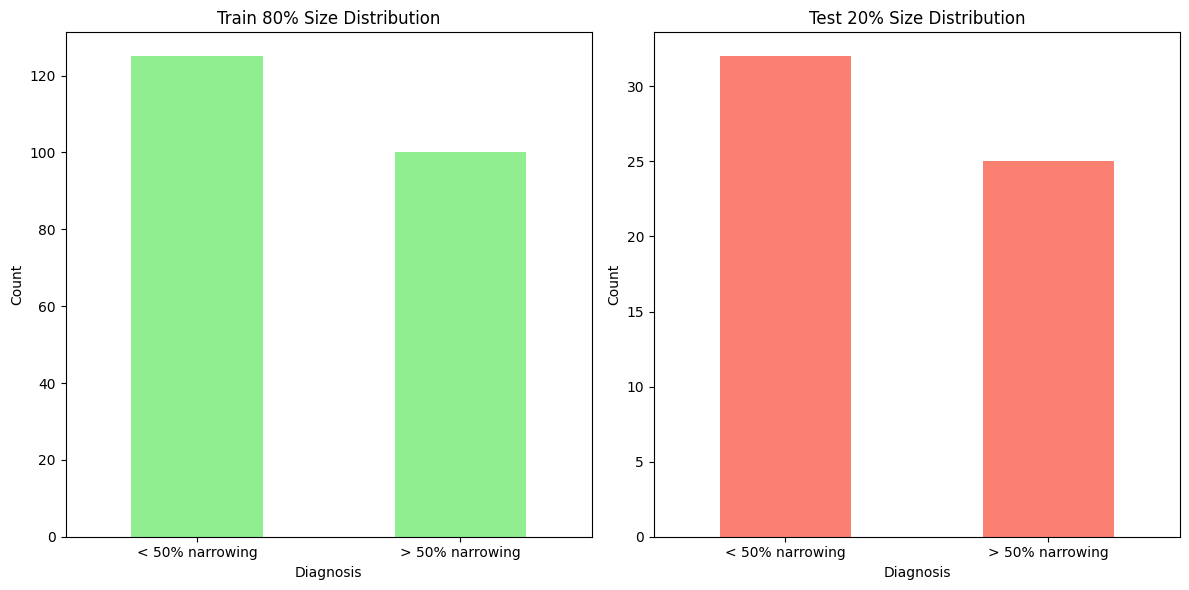

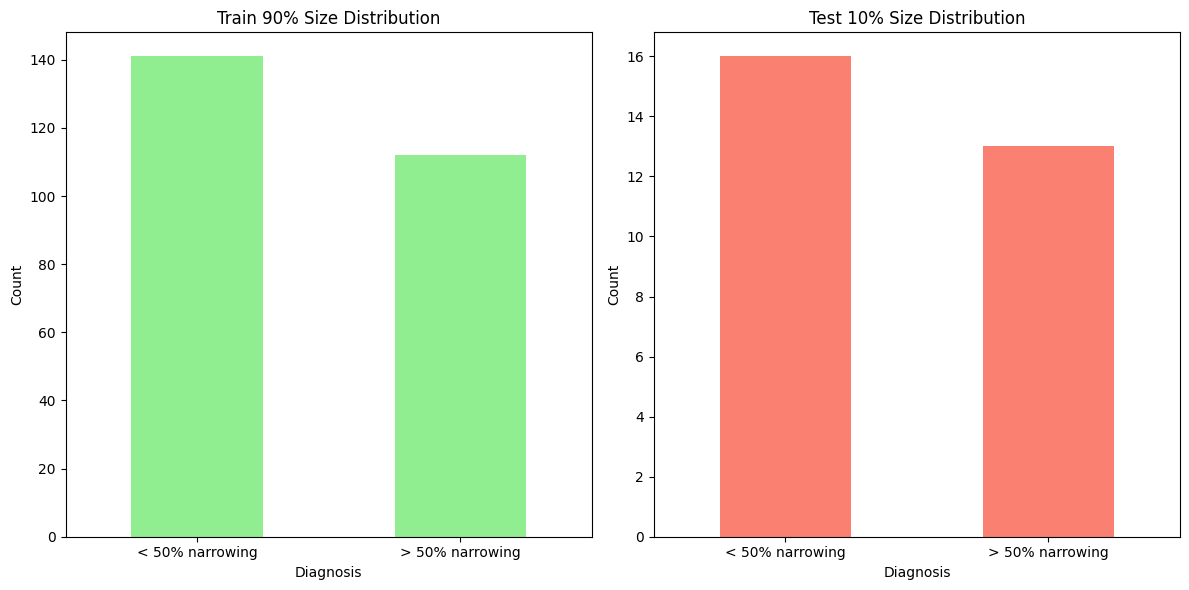

In [78]:
# Hàm vẽ phân phối lớp trong tập train/test
def plot_subset_class_distribution(subsets):
    for subset in subsets:
        train_size = subset['train_size']
        y_train = subset['y_train']
        y_test = subset['y_test']
        
        plt.figure(figsize=(12, 6))
        
        # Plot train class distribution
        train_class_dist = pd.Series(y_train).value_counts().sort_index()
        plt.subplot(1, 2, 1)
        train_class_dist.plot(kind='bar', color='lightgreen')
        plt.title(f"Train {int(train_size*100)}% Size Distribution")
        plt.xlabel("Diagnosis")
        plt.ylabel("Count")
        plt.xticks(ticks=range(len(train_class_dist)), labels=['< 50% narrowing', '> 50% narrowing'], rotation=0)
        
        # Plot test class distribution
        test_class_dist = pd.Series(y_test).value_counts().sort_index()
        plt.subplot(1, 2, 2)
        test_class_dist.plot(kind='bar', color='salmon')
        plt.title(f"Test {math.ceil((1-train_size)*100)}% Size Distribution")
        plt.xlabel("Diagnosis")
        plt.ylabel("Count")
        plt.xticks(ticks=range(len(test_class_dist)), labels=['< 50% narrowing', '> 50% narrowing'], rotation=0)
        
        plt.tight_layout()
        plt.show()

    # Hiển thị phân phối lớp
plot_subset_class_distribution(subset_data)


## 2. Experiments

In [79]:
# Hàm vẽ confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar=True)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.title('Decision Tree Classifier confusion matrix', fontsize=14)
    plt.tight_layout()
    
    plt.show()

In [80]:
# Hàm trực quan hóa cây quyết định
def visualize_decision_tree(max_depth, feature_names, class_names, model, data):
    dot_data = export_graphviz(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    
    graph = Source(dot_data)
    filename = f"tree_depth_{max_depth}_train_{int(data['train_size'] * 100)}"
    graph.render(filename, format="png", cleanup=True)
    
    img_path = f"{filename}.png"
    display(Image(filename=img_path))
    print(f"Saved decision tree as {img_path}")


=== Experiment with Train Size: 40% ===
=== Visualizing Decision Tree (max_depth=3) ===


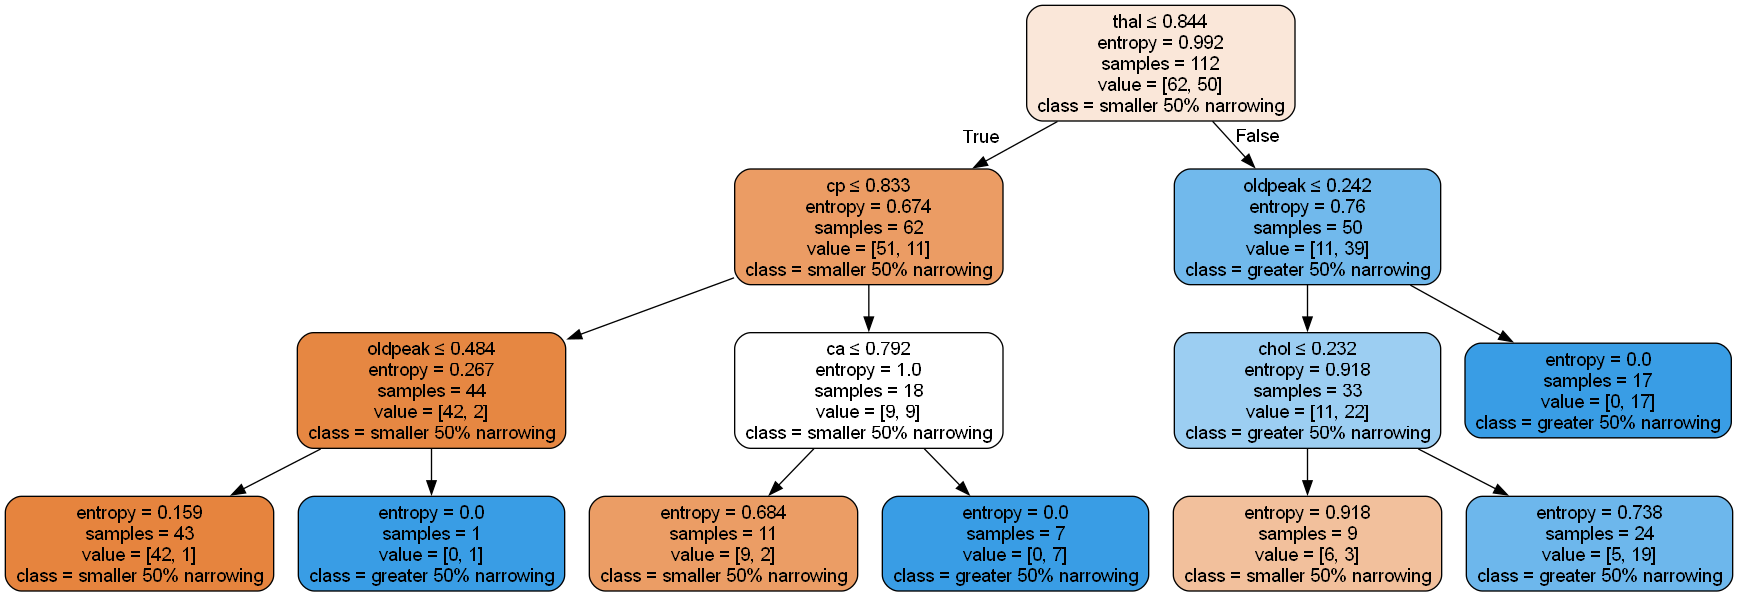

Saved decision tree as tree_depth_3_train_40.png
=== Classification Report ===
                       precision    recall  f1-score   support

smaller 50% narrowing       0.80      0.82      0.81        95
greater 50% narrowing       0.76      0.73      0.75        75

             accuracy                           0.78       170
            macro avg       0.78      0.78      0.78       170
         weighted avg       0.78      0.78      0.78       170

=== Confusion Matrix (saved as confusion_matrix_train_size_40.png) ===


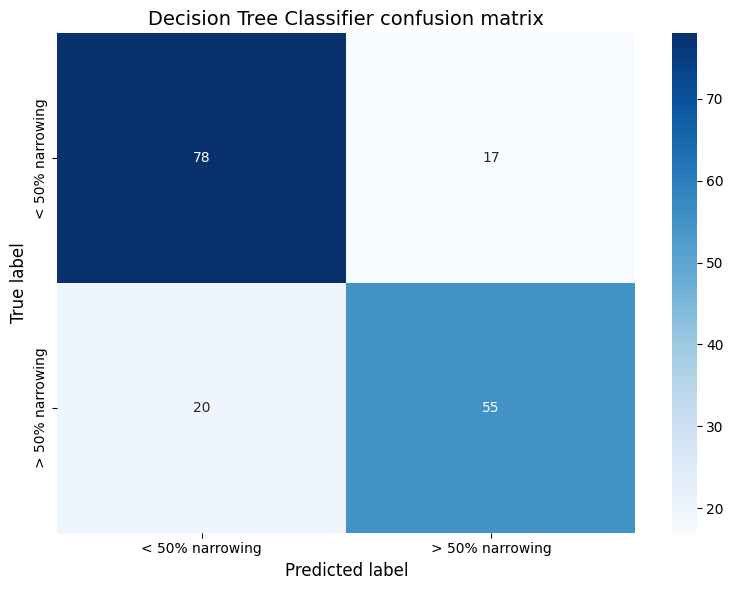

=== Visualizing Decision Tree (max_depth=4) ===


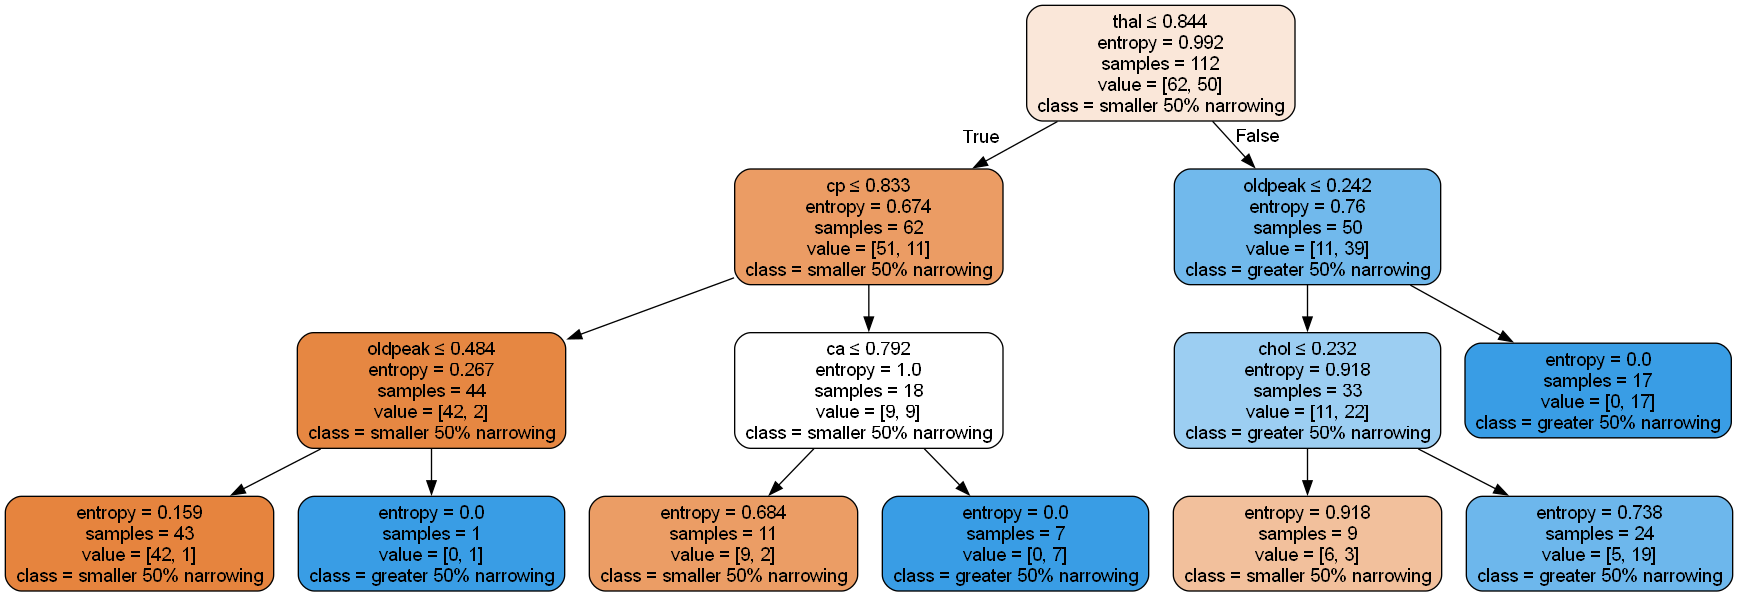

Saved decision tree as tree_depth_4_train_40.png

=== Experiment with Train Size: 60% ===
=== Visualizing Decision Tree (max_depth=3) ===


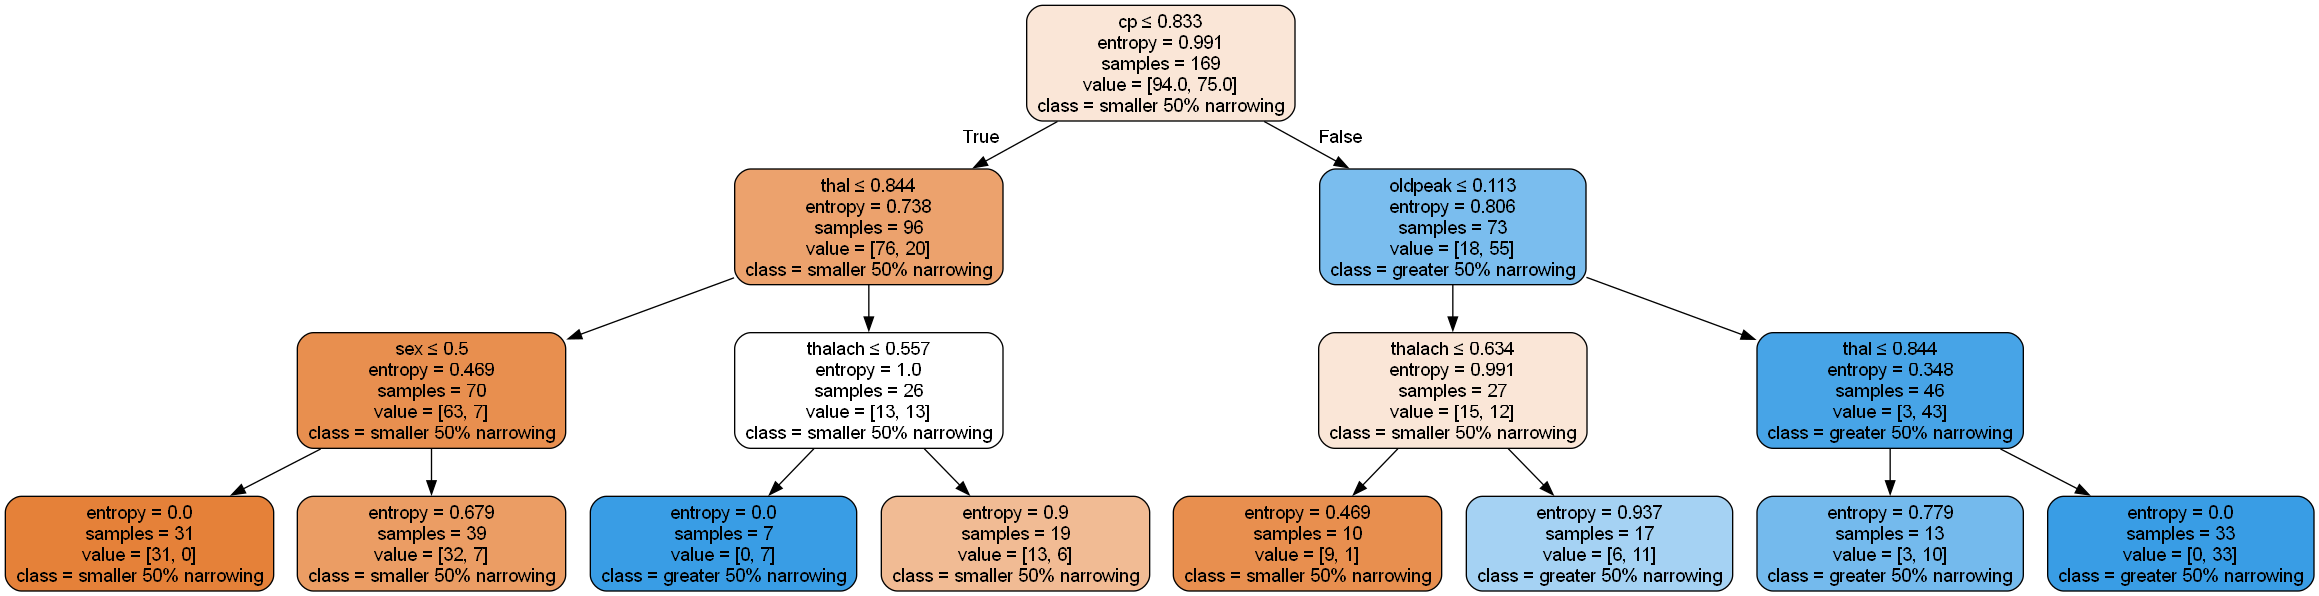

Saved decision tree as tree_depth_3_train_60.png
=== Classification Report ===
                       precision    recall  f1-score   support

smaller 50% narrowing       0.74      0.71      0.73        63
greater 50% narrowing       0.65      0.68      0.67        50

             accuracy                           0.70       113
            macro avg       0.70      0.70      0.70       113
         weighted avg       0.70      0.70      0.70       113

=== Confusion Matrix (saved as confusion_matrix_train_size_60.png) ===


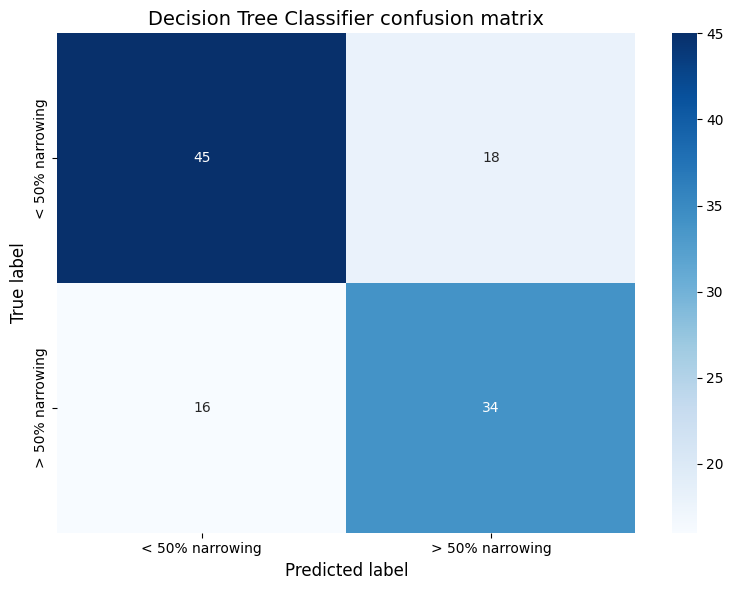

=== Visualizing Decision Tree (max_depth=4) ===


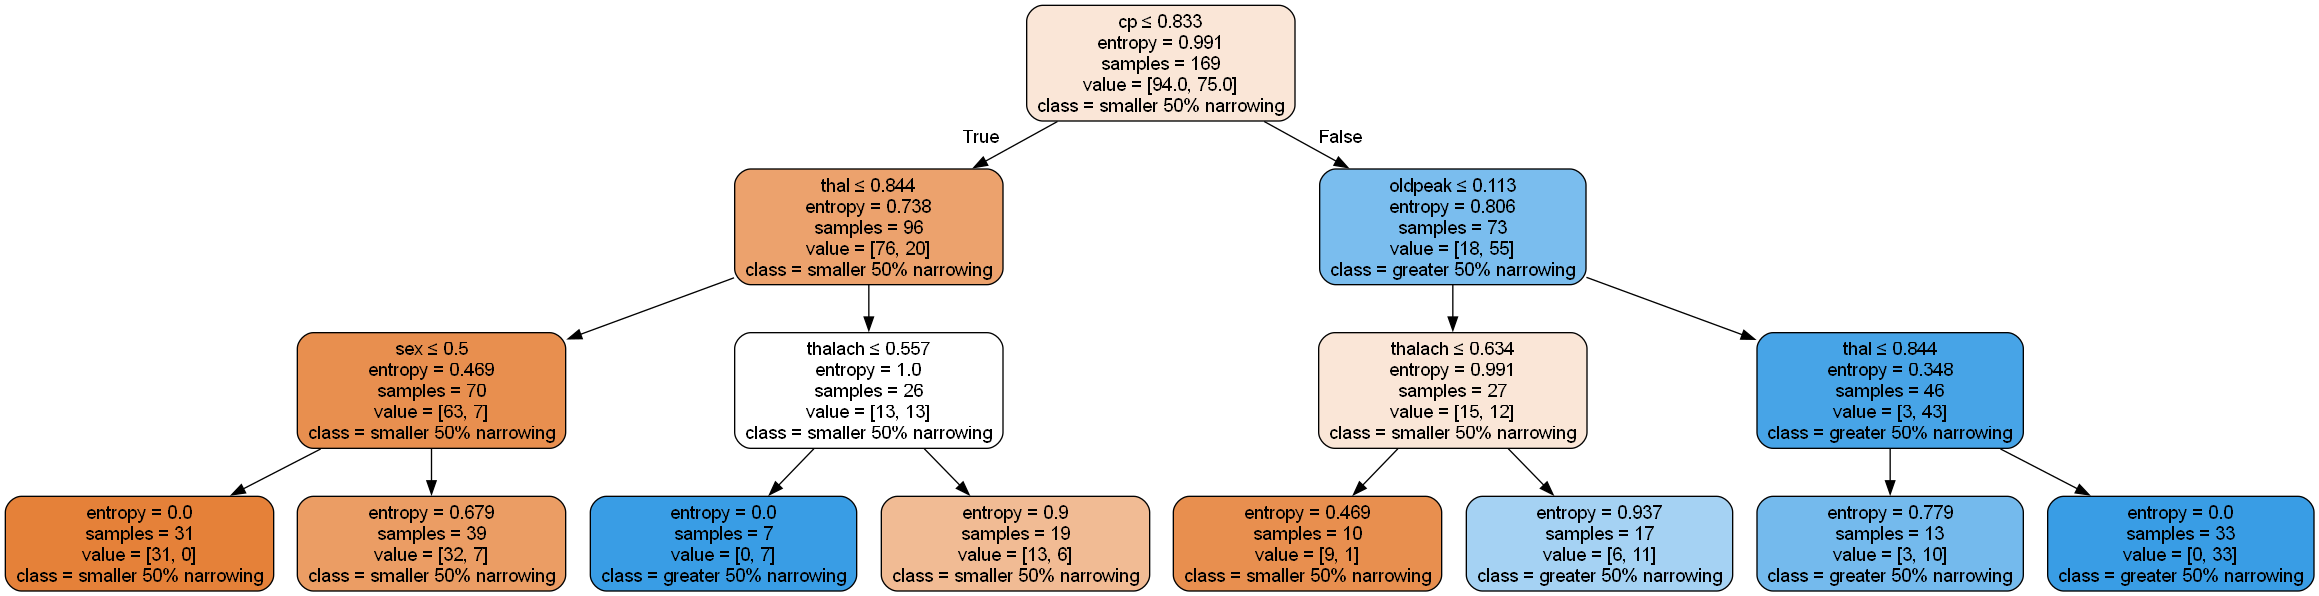

Saved decision tree as tree_depth_4_train_60.png

=== Experiment with Train Size: 80% ===
=== Visualizing Decision Tree (max_depth=3) ===


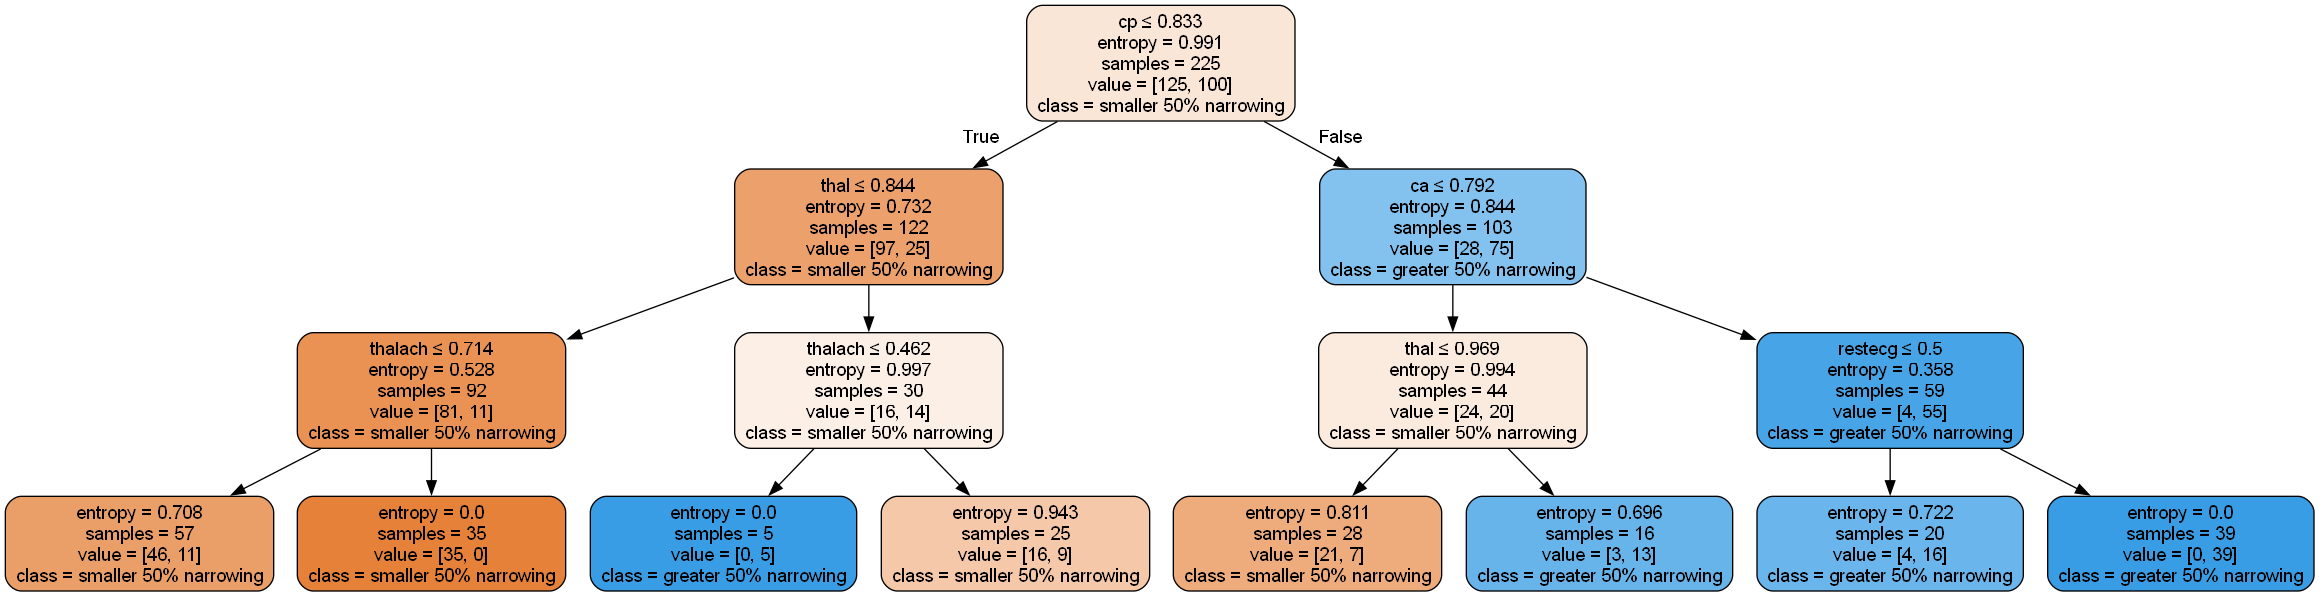

Saved decision tree as tree_depth_3_train_80.png
=== Classification Report ===
                       precision    recall  f1-score   support

smaller 50% narrowing       0.81      0.91      0.85        32
greater 50% narrowing       0.86      0.72      0.78        25

             accuracy                           0.82        57
            macro avg       0.83      0.81      0.82        57
         weighted avg       0.83      0.82      0.82        57

=== Confusion Matrix (saved as confusion_matrix_train_size_80.png) ===


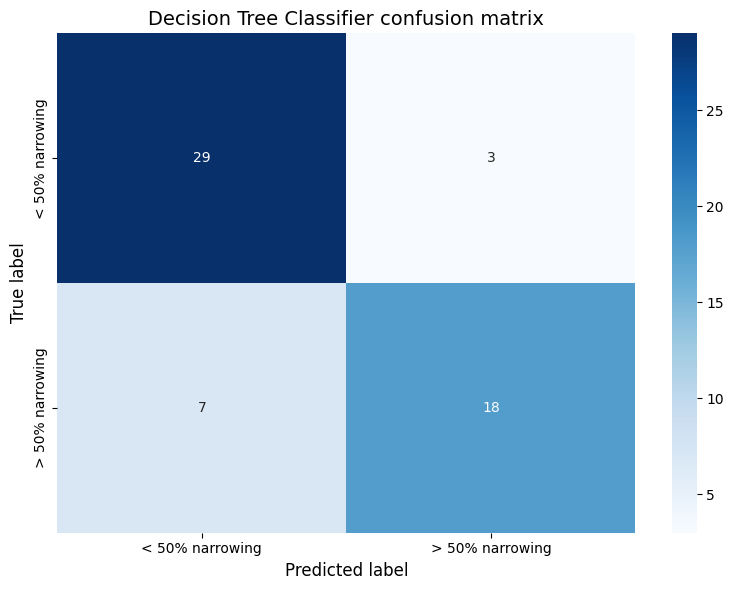

=== Visualizing Decision Tree (max_depth=4) ===


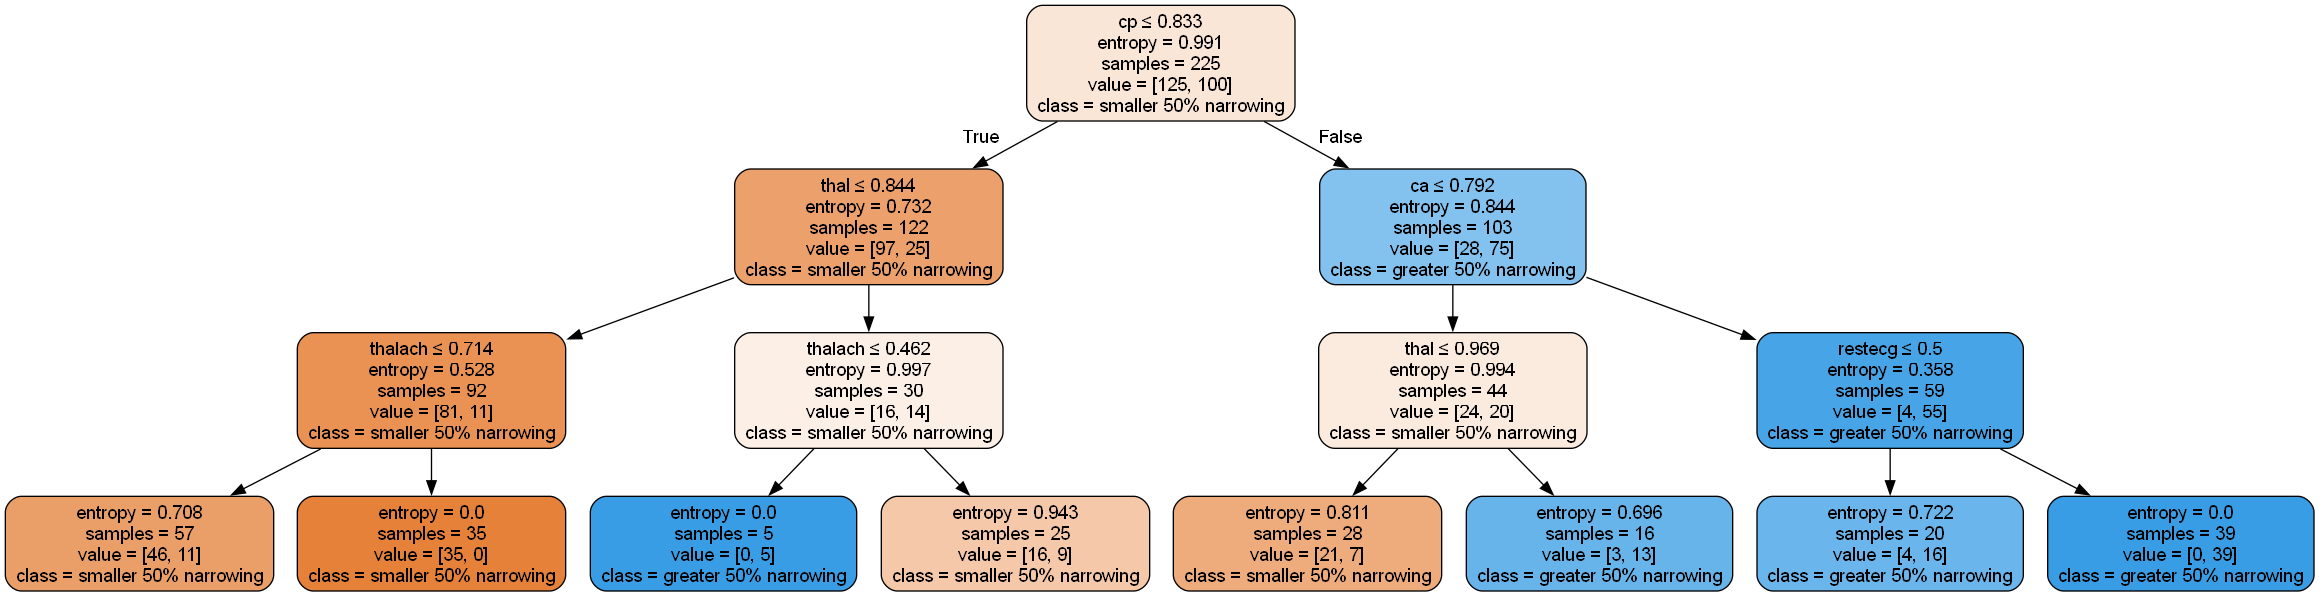

Saved decision tree as tree_depth_4_train_80.png

=== Experiment with Train Size: 90% ===
=== Visualizing Decision Tree (max_depth=3) ===


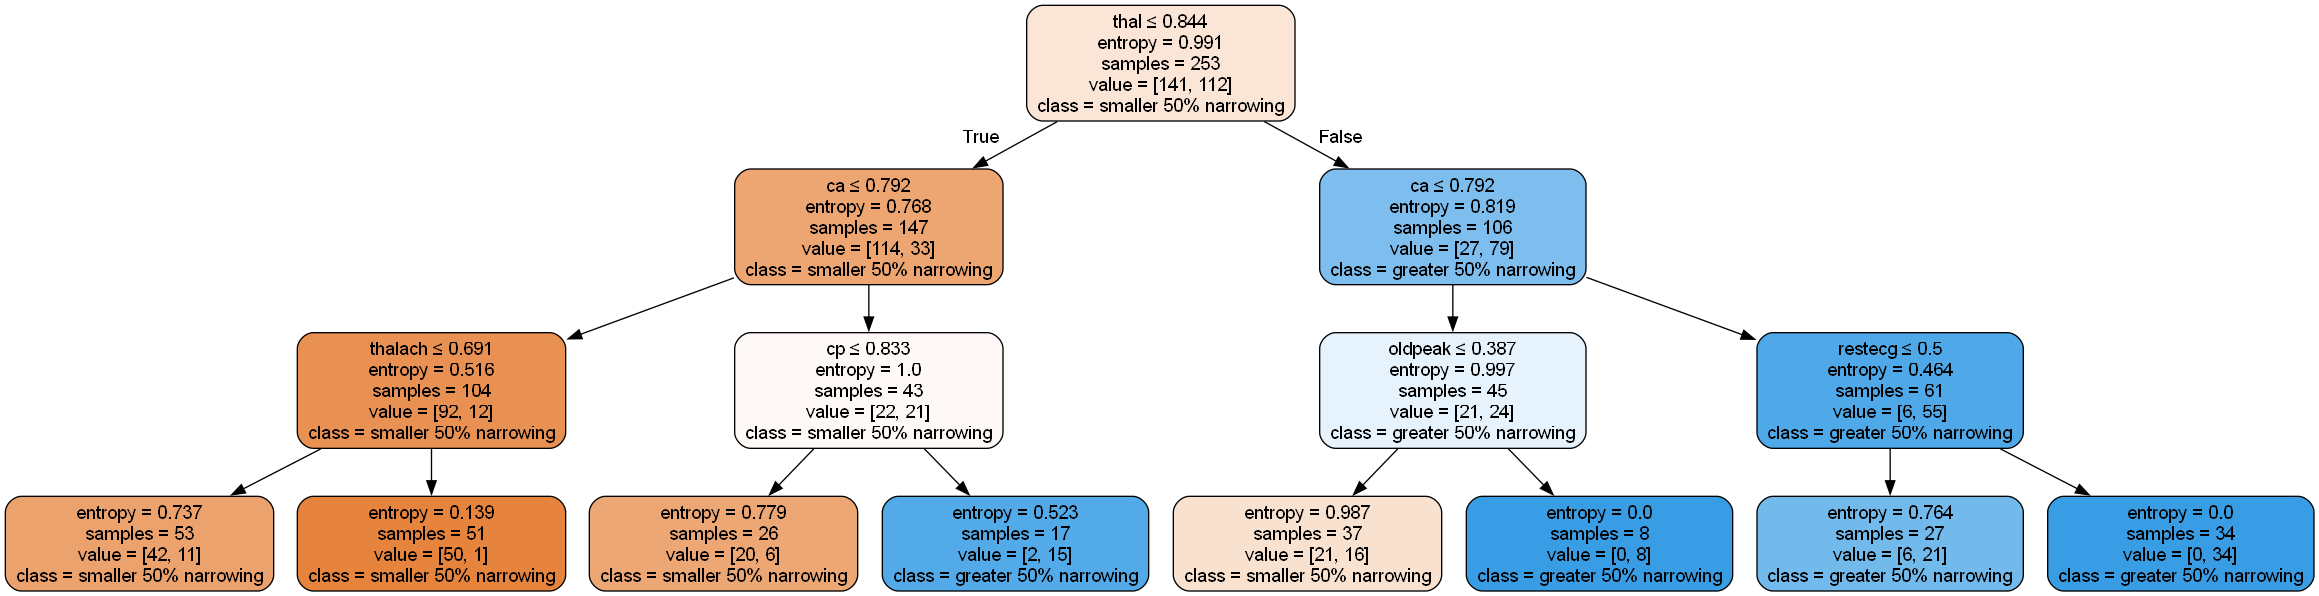

Saved decision tree as tree_depth_3_train_90.png
=== Classification Report ===
                       precision    recall  f1-score   support

smaller 50% narrowing       0.70      0.88      0.78        16
greater 50% narrowing       0.78      0.54      0.64        13

             accuracy                           0.72        29
            macro avg       0.74      0.71      0.71        29
         weighted avg       0.73      0.72      0.71        29

=== Confusion Matrix (saved as confusion_matrix_train_size_90.png) ===


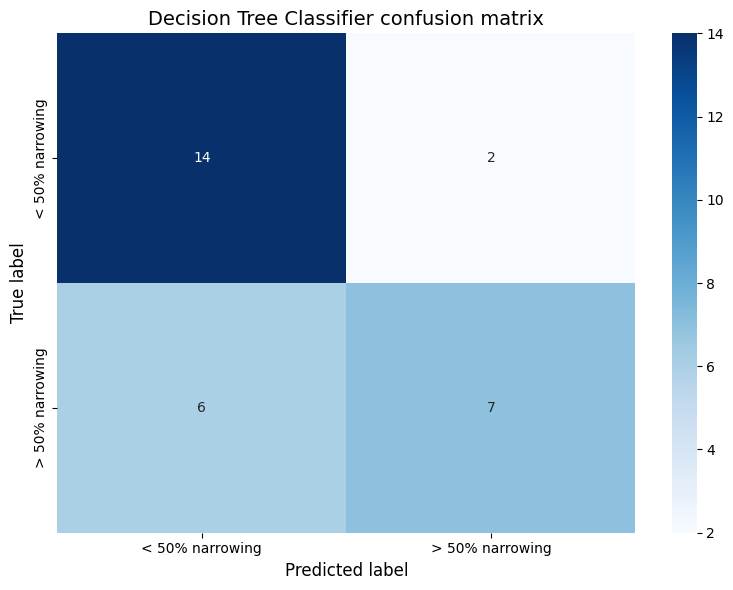

=== Visualizing Decision Tree (max_depth=4) ===


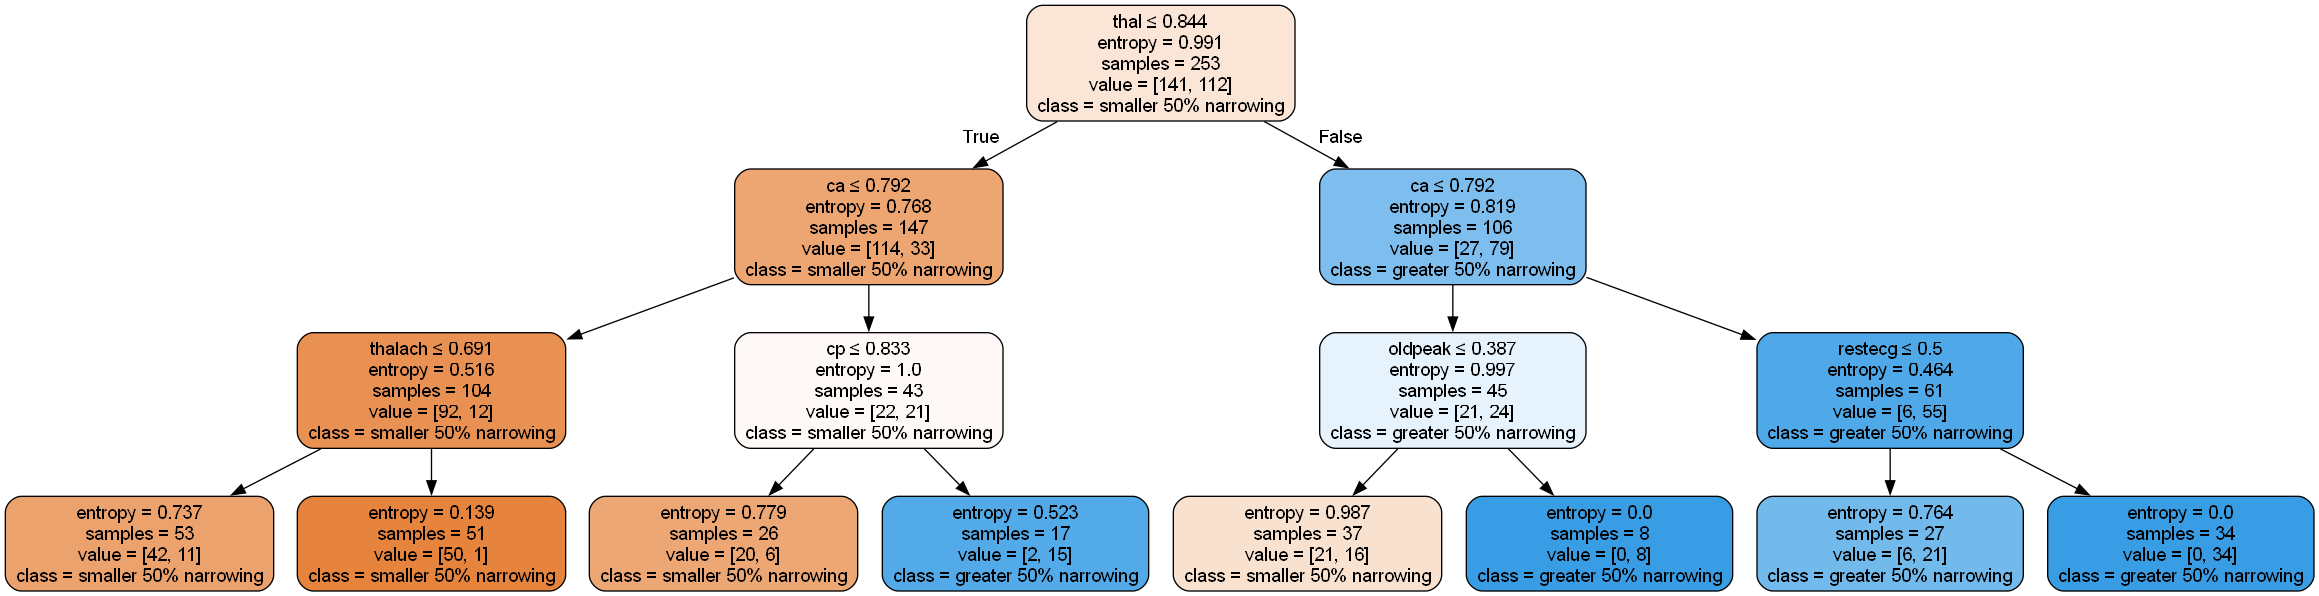

Saved decision tree as tree_depth_4_train_90.png


In [81]:
for data in subset_data:
    print(f"\n=== Experiment with Train Size: {int(data['train_size'] * 100)}% ===")
    
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
    model.fit(data['X_train'], data['y_train'])

    # Hiển thị cây quyết định (max_depth=3)
    print("=== Visualizing Decision Tree (max_depth=3) ===")
    visualize_decision_tree(
        max_depth=3, 
        feature_names=X.columns, 
        class_names=['smaller 50% narrowing', 'greater 50% narrowing'],  
        model=model,
        data=data
    )
    
    # Đánh giá mô hình
    y_pred = model.predict(data['X_test'])
    print("=== Classification Report ===")
    report = classification_report(data['y_test'], y_pred, target_names=['smaller 50% narrowing', 'greater 50% narrowing'])
    print(report)
        
    # confusion matrix
    cm = confusion_matrix(data['y_test'], y_pred)
    filename = f'confusion_matrix_train_size_{int(data["train_size"] * 100)}.png'
    print(f"=== Confusion Matrix (saved as {filename}) ===")
    plot_confusion_matrix(cm, classes=['< 50% narrowing', '> 50% narrowing'])

    # Hiển thị cây quyết định (max_depth=4)
    print("=== Visualizing Decision Tree (max_depth=4) ===")
    visualize_decision_tree(
        max_depth=4, 
        feature_names=X.columns, 
        class_names=['smaller 50% narrowing', 'greater 50% narrowing'], 
        model=model,
        data=data
    )


## 3. Evaluate the depth of the decision tree

In [82]:
# Hàm đánh giá độ sâu cây quyết định
def evaluate_decision_tree_depths(X, y, max_depths):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    results = []
    
    for depth in max_depths:
        model = DecisionTreeClassifier(max_depth=depth, criterion='entropy', random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        depth_label = 'Unlimited' if depth is None else depth
        
        results.append({'max_depth': depth_label, 'accuracy': accuracy})
        
        visualize_decision_tree(depth, X.columns, ['smaller 50% narrowing', 'greater 50% narrowing'], model, {'train_size': 0.8})
        
        plt.figure(figsize=(20, 10))
        plot_tree(model, feature_names=X.columns, class_names=['< 50% narrowing', '> 50% narrowing'], 
                 filled=True, rounded=True)
        plt.title(f'Decision Tree (max_depth = {depth_label})')
        plt.show()
        
        print(f"\nClassification Report for max_depth={depth_label}:")
        print(classification_report(y_test, y_pred, target_names=['< 50% narrowing', '> 50% narrowing']))
        
        cm = confusion_matrix(y_test, y_pred)
        filename = f'confusion_matrix_depth_{depth_label}.png'
        plot_confusion_matrix(cm, classes=['< 50% narrowing', '> 50% narrowing'])
    
    results_df = pd.DataFrame(results)
    
    # Print accuracy summary
    print("\nAccuracy for Different Decision Tree Depths:")
    print(results_df.to_string(index=False))
    
    # Plot accuracy vs max depth
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(results)), results_df['accuracy'], marker='o', color='#1f77b4')
    plt.title('Decision Tree Accuracy vs Max Depth')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(results)), results_df['max_depth'])
    plt.grid(True)

    plt.show()
    
    return results_df

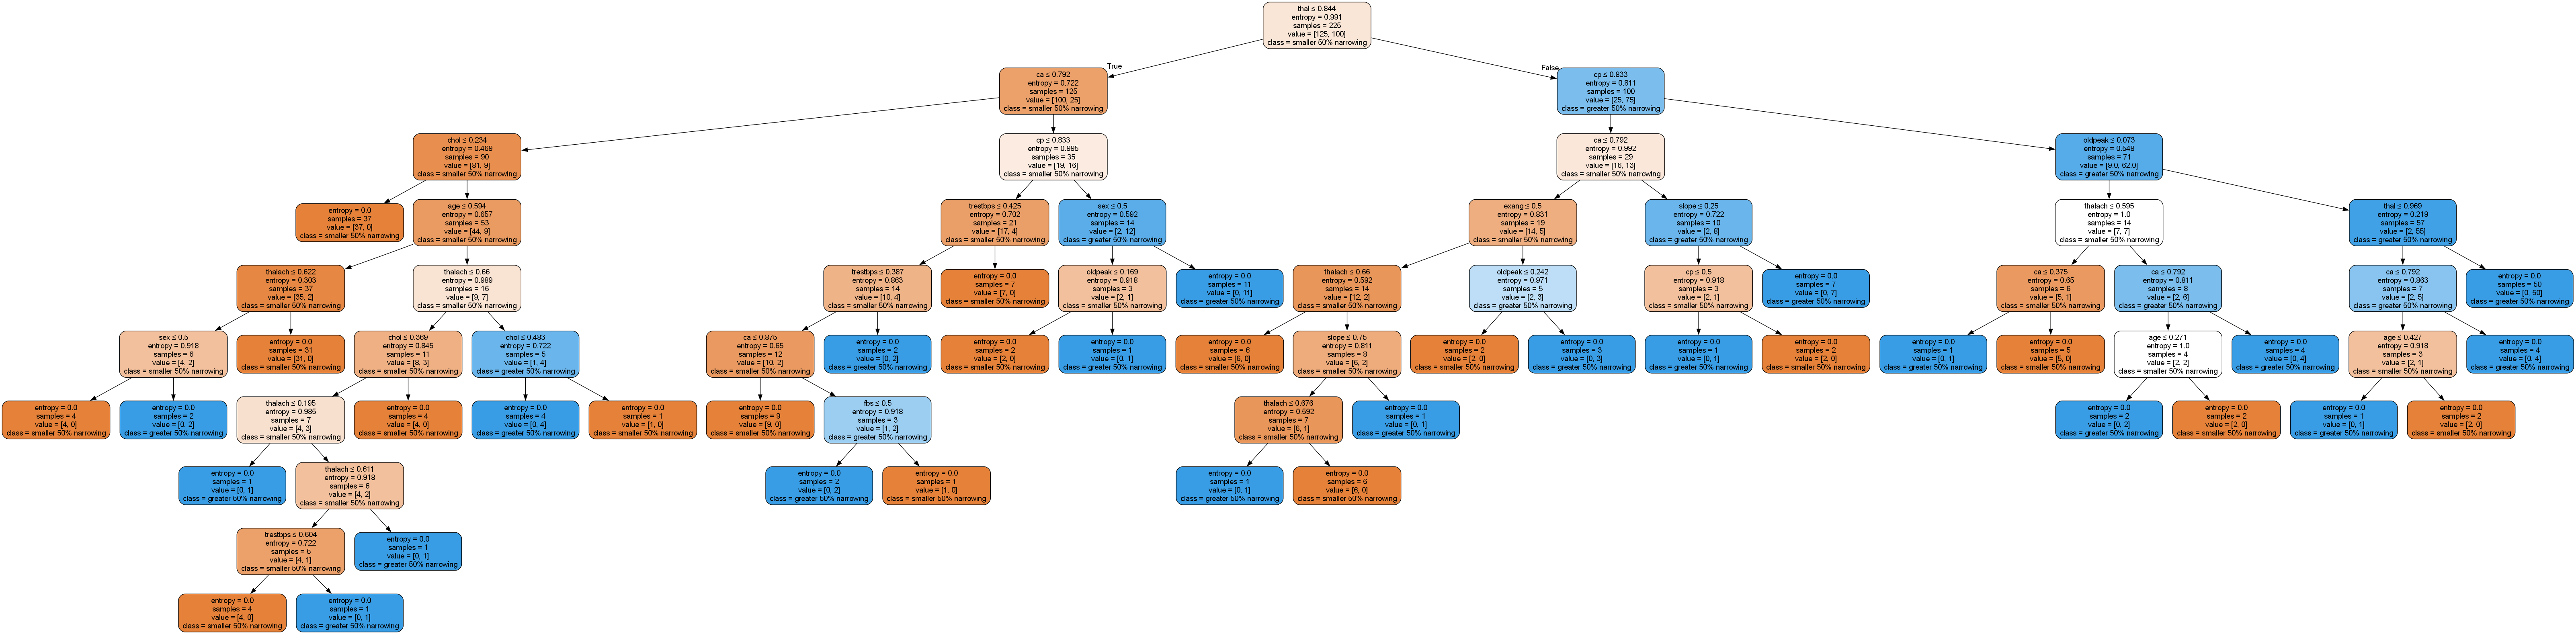

Saved decision tree as tree_depth_None_train_80.png


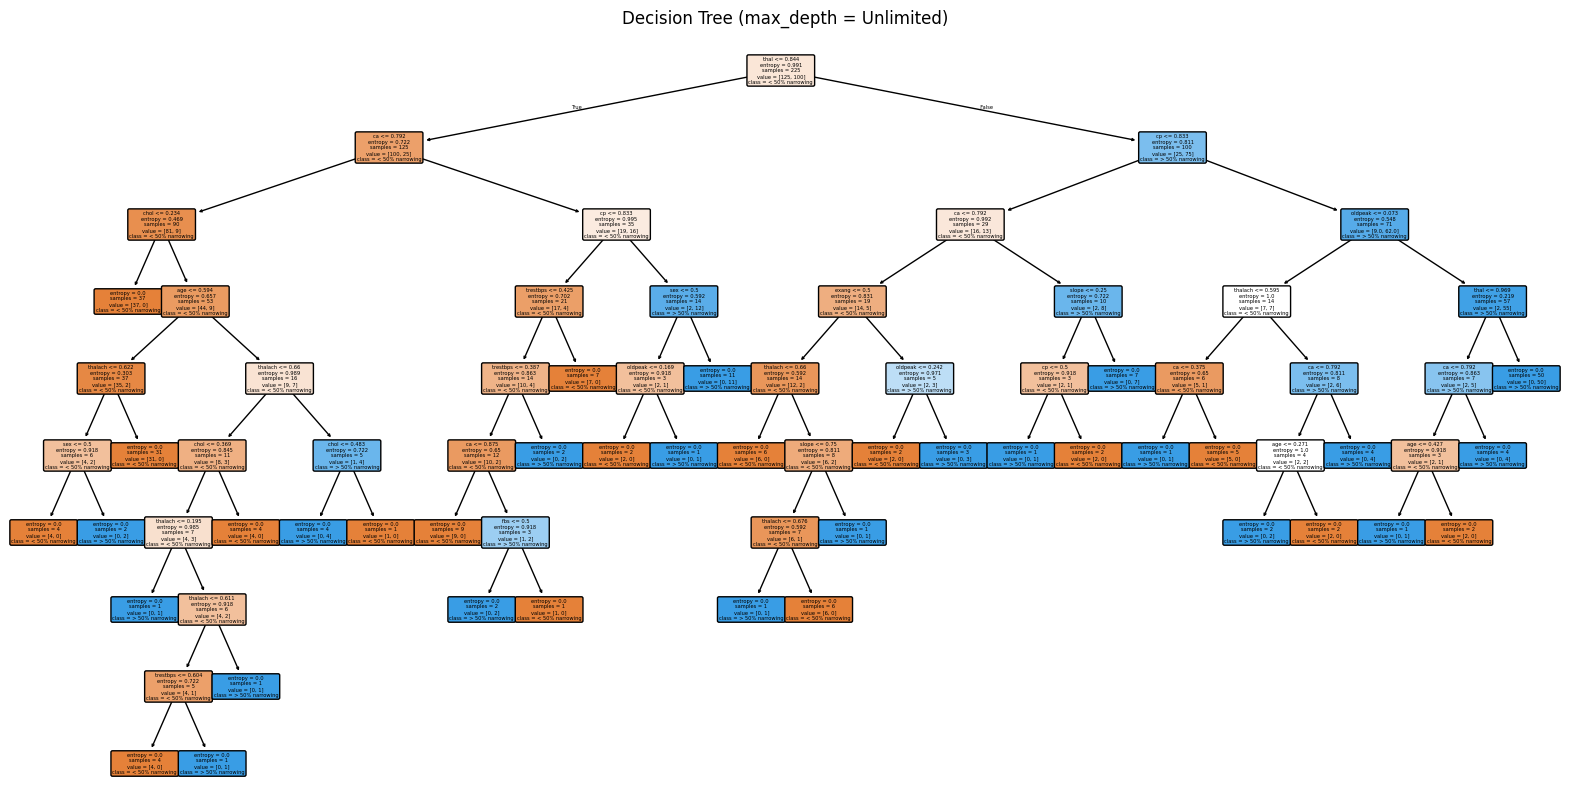


Classification Report for max_depth=Unlimited:
                 precision    recall  f1-score   support

< 50% narrowing       0.77      0.75      0.76        32
> 50% narrowing       0.69      0.72      0.71        25

       accuracy                           0.74        57
      macro avg       0.73      0.73      0.73        57
   weighted avg       0.74      0.74      0.74        57



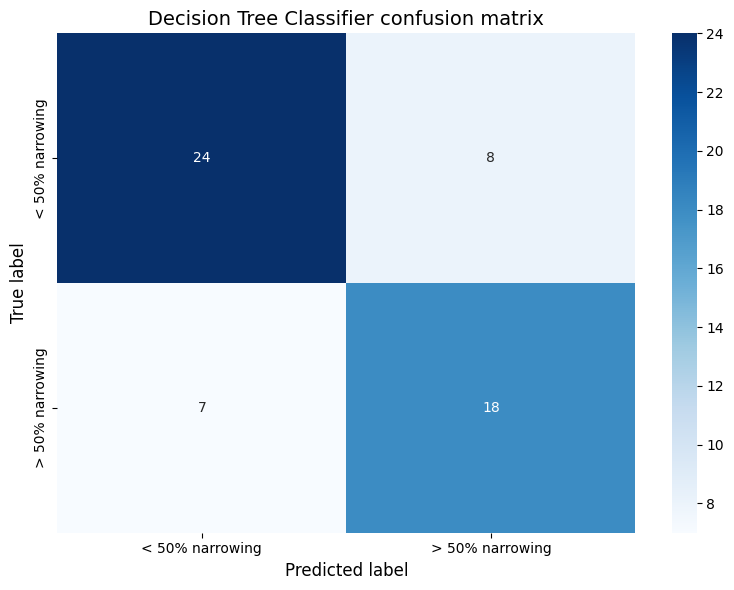

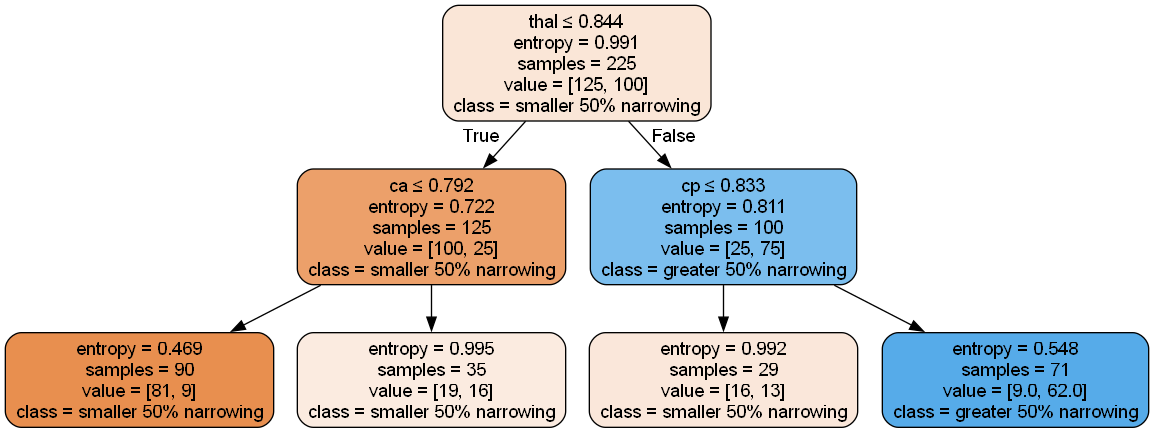

Saved decision tree as tree_depth_2_train_80.png


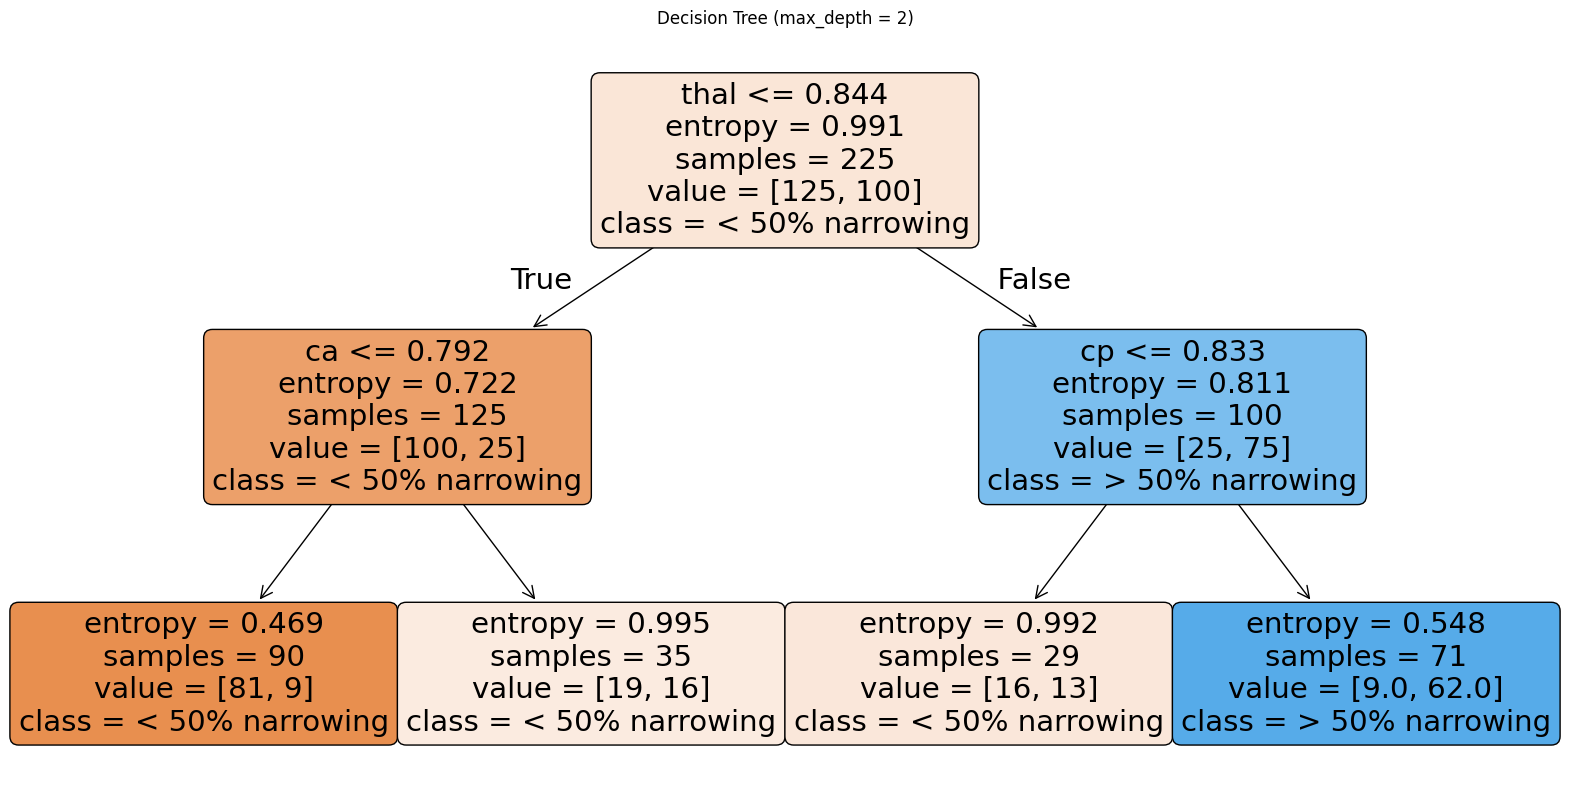


Classification Report for max_depth=2:
                 precision    recall  f1-score   support

< 50% narrowing       0.65      0.97      0.78        32
> 50% narrowing       0.89      0.32      0.47        25

       accuracy                           0.68        57
      macro avg       0.77      0.64      0.62        57
   weighted avg       0.75      0.68      0.64        57



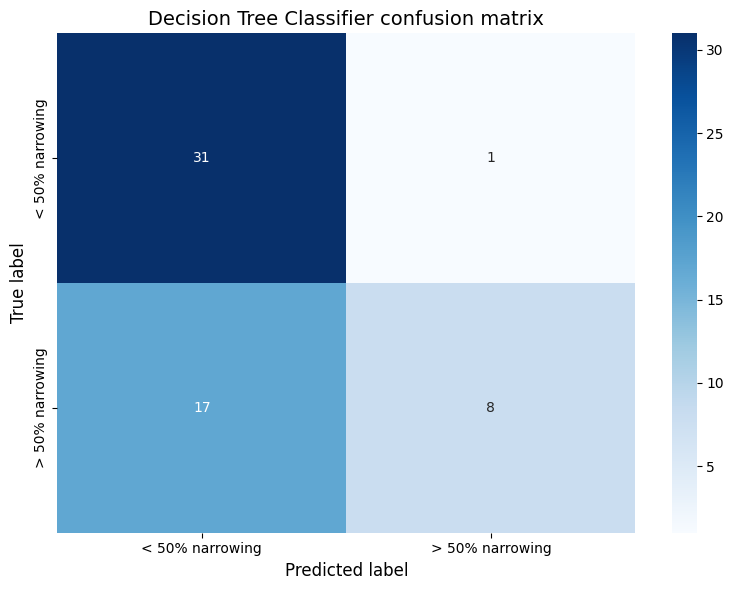

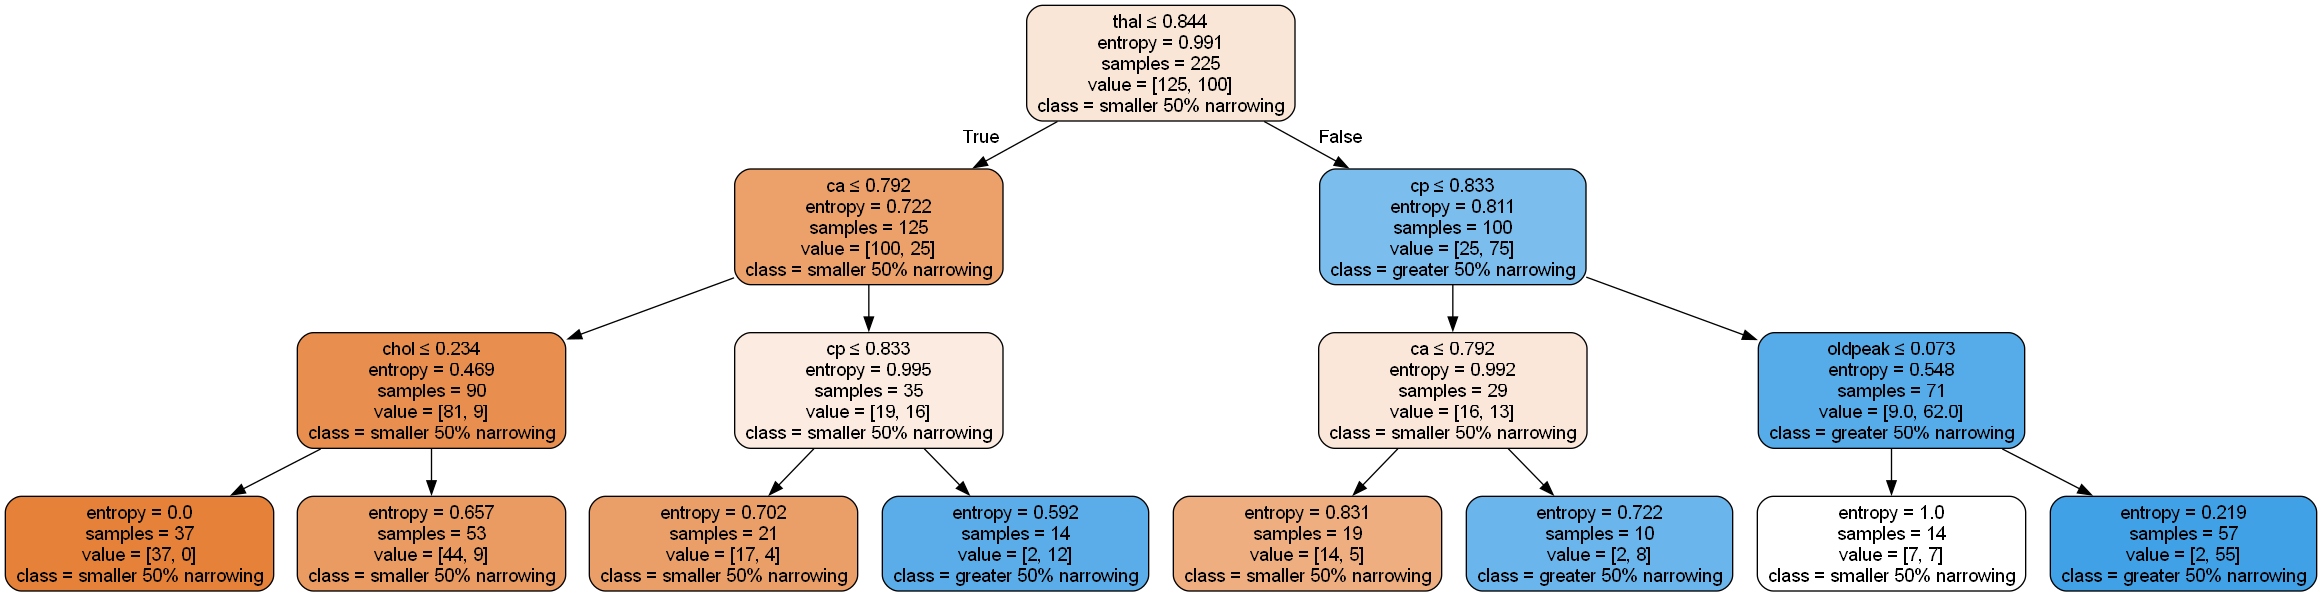

Saved decision tree as tree_depth_3_train_80.png


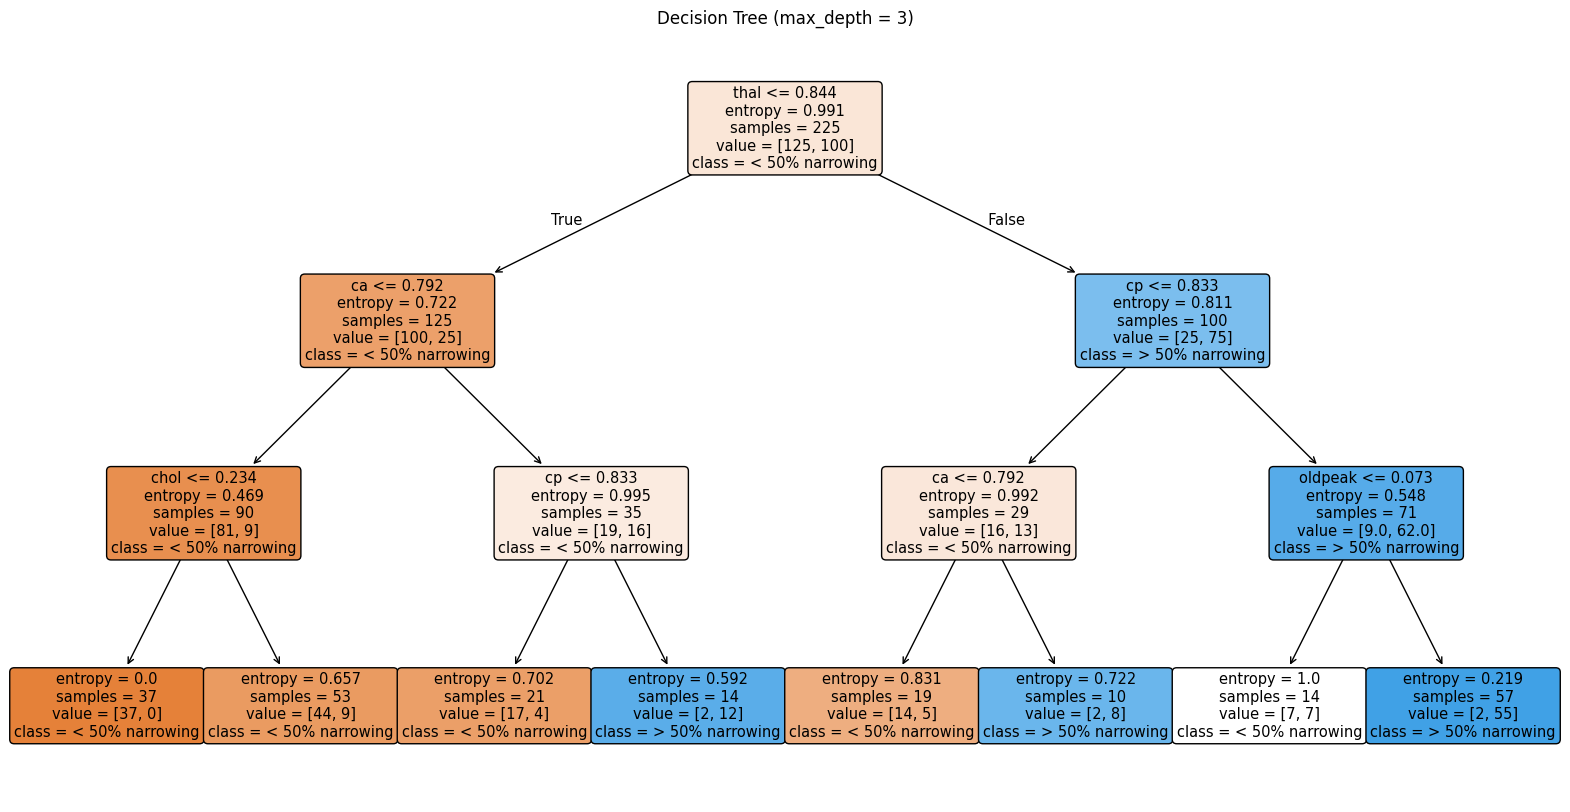


Classification Report for max_depth=3:
                 precision    recall  f1-score   support

< 50% narrowing       0.72      0.88      0.79        32
> 50% narrowing       0.78      0.56      0.65        25

       accuracy                           0.74        57
      macro avg       0.75      0.72      0.72        57
   weighted avg       0.74      0.74      0.73        57



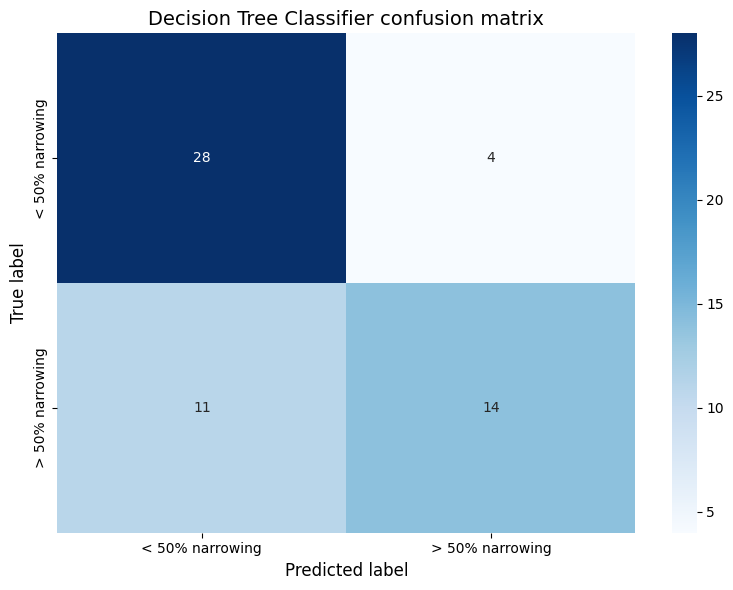

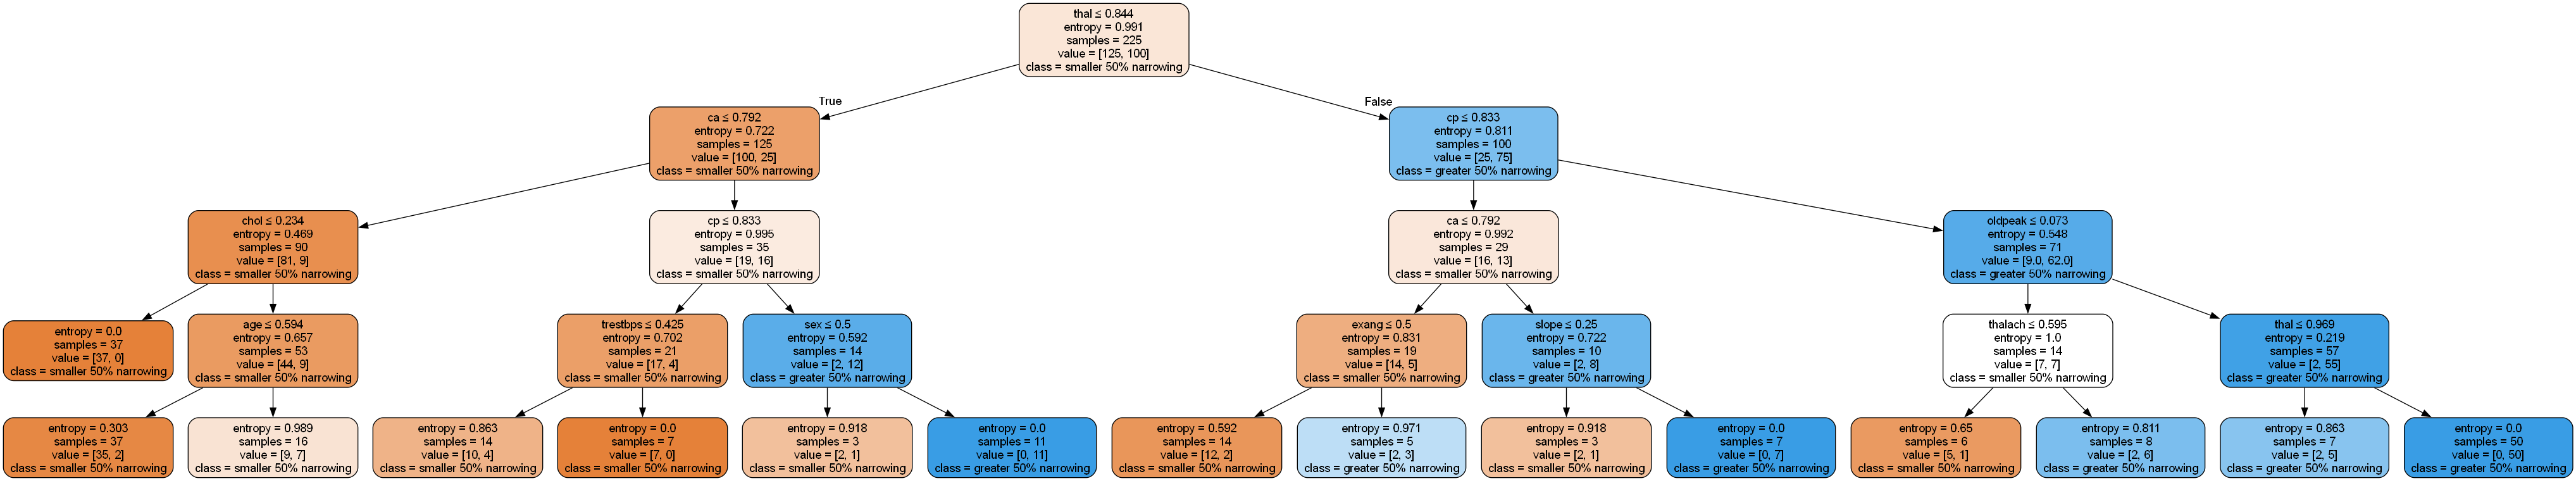

Saved decision tree as tree_depth_4_train_80.png


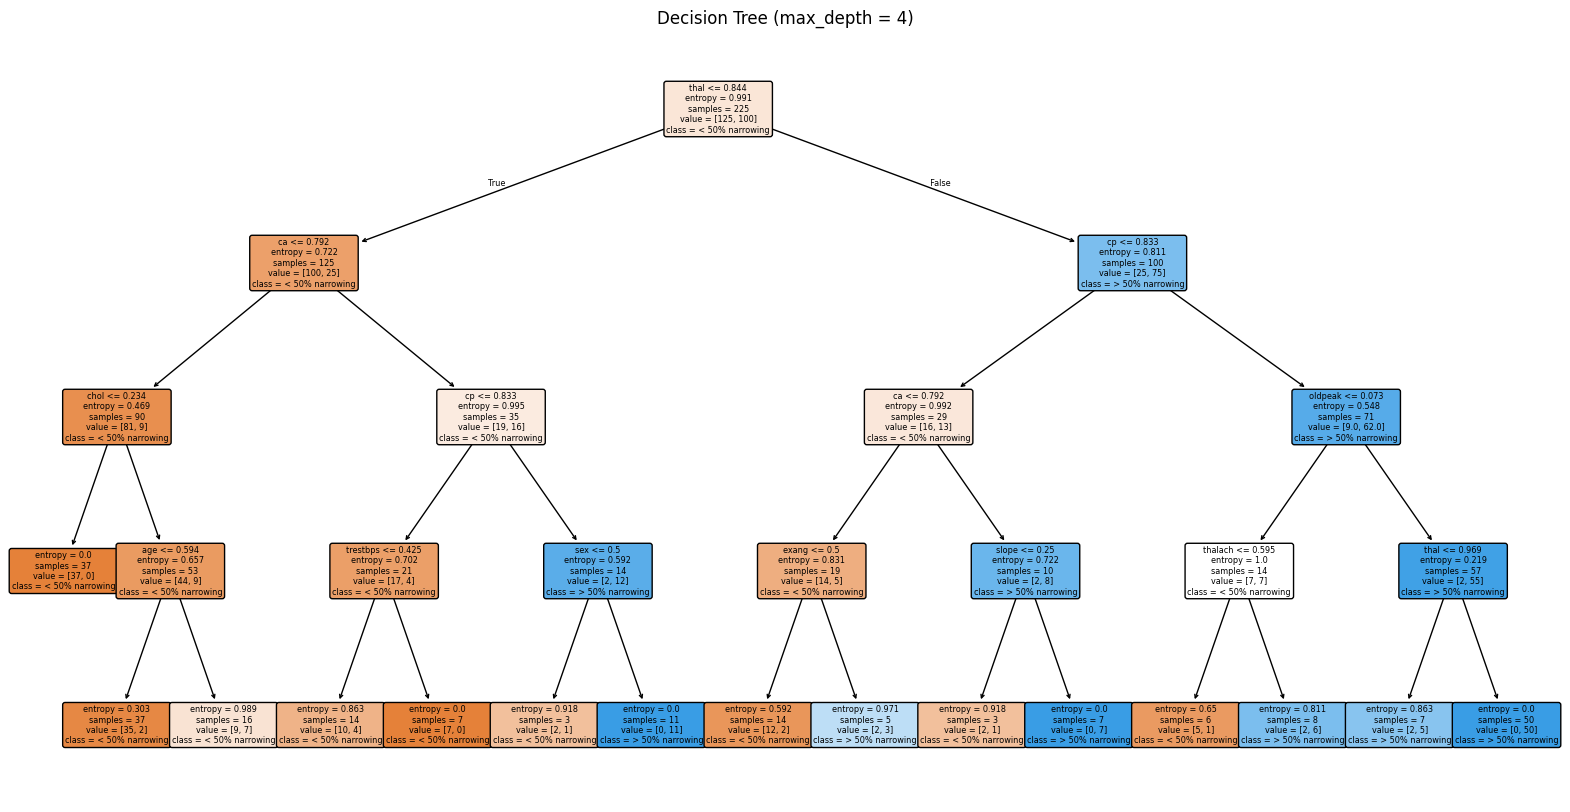


Classification Report for max_depth=4:
                 precision    recall  f1-score   support

< 50% narrowing       0.73      0.94      0.82        32
> 50% narrowing       0.88      0.56      0.68        25

       accuracy                           0.77        57
      macro avg       0.80      0.75      0.75        57
   weighted avg       0.79      0.77      0.76        57



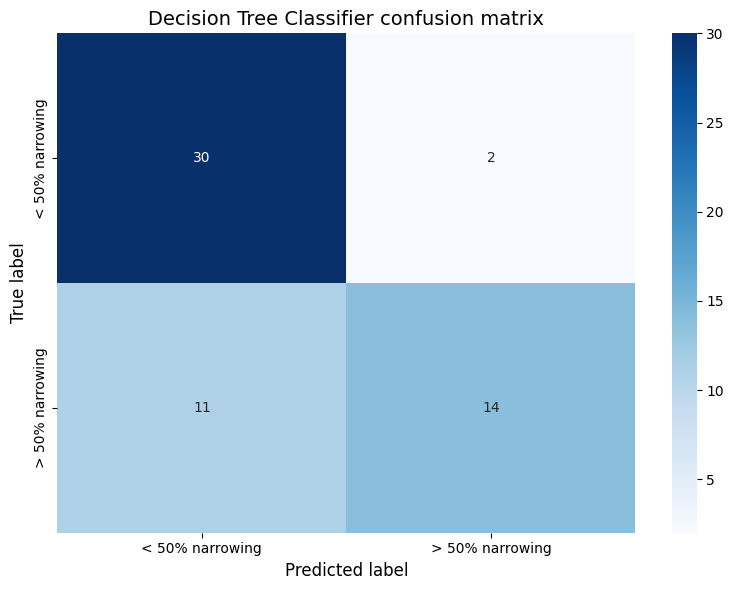

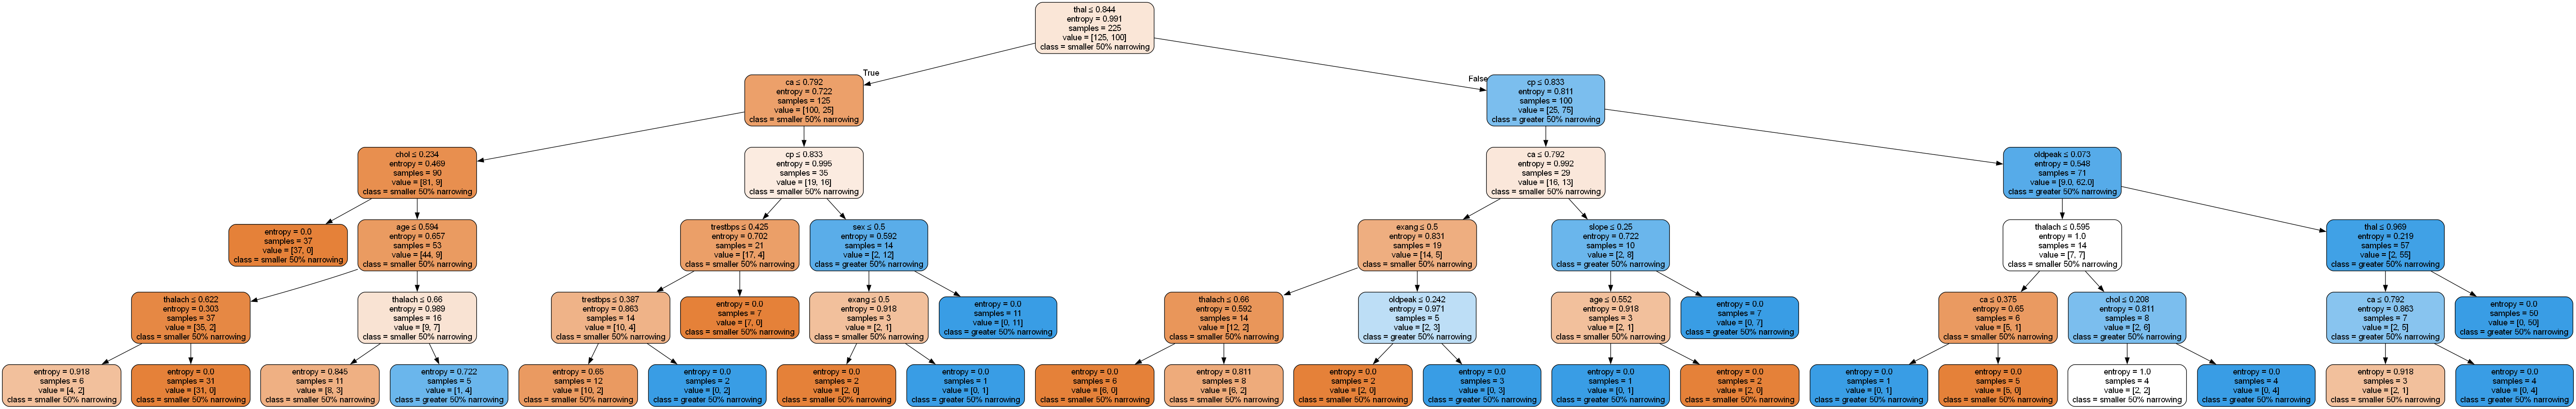

Saved decision tree as tree_depth_5_train_80.png


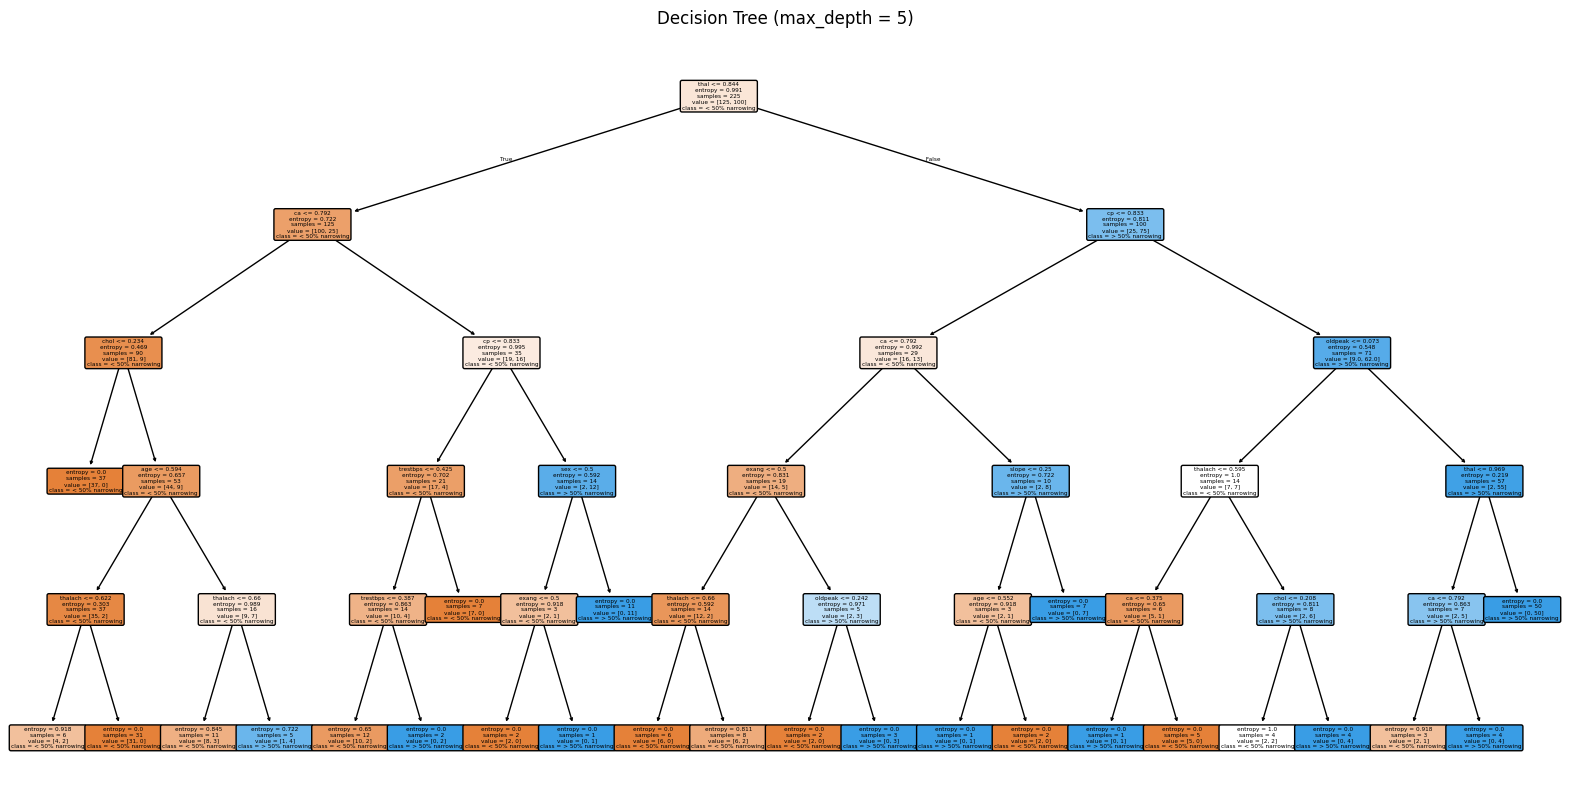


Classification Report for max_depth=5:
                 precision    recall  f1-score   support

< 50% narrowing       0.69      0.78      0.74        32
> 50% narrowing       0.67      0.56      0.61        25

       accuracy                           0.68        57
      macro avg       0.68      0.67      0.67        57
   weighted avg       0.68      0.68      0.68        57



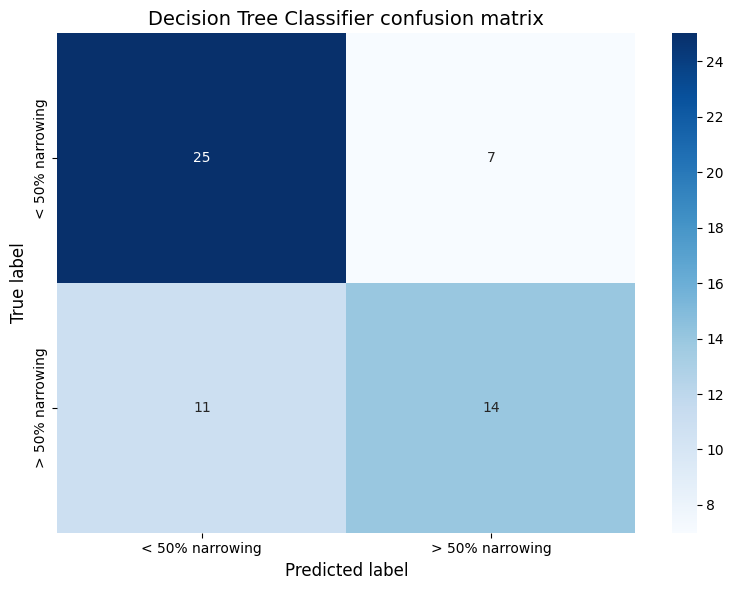

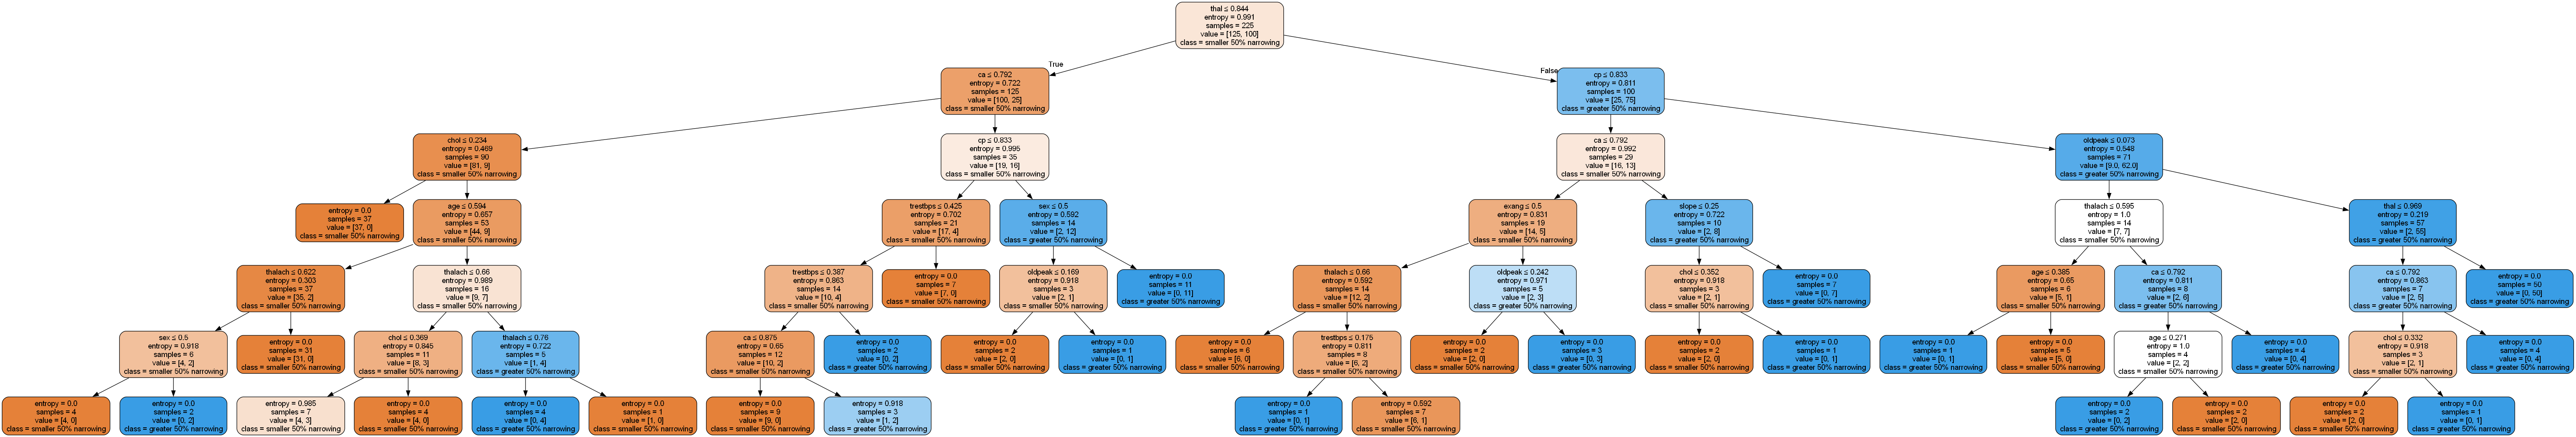

Saved decision tree as tree_depth_6_train_80.png


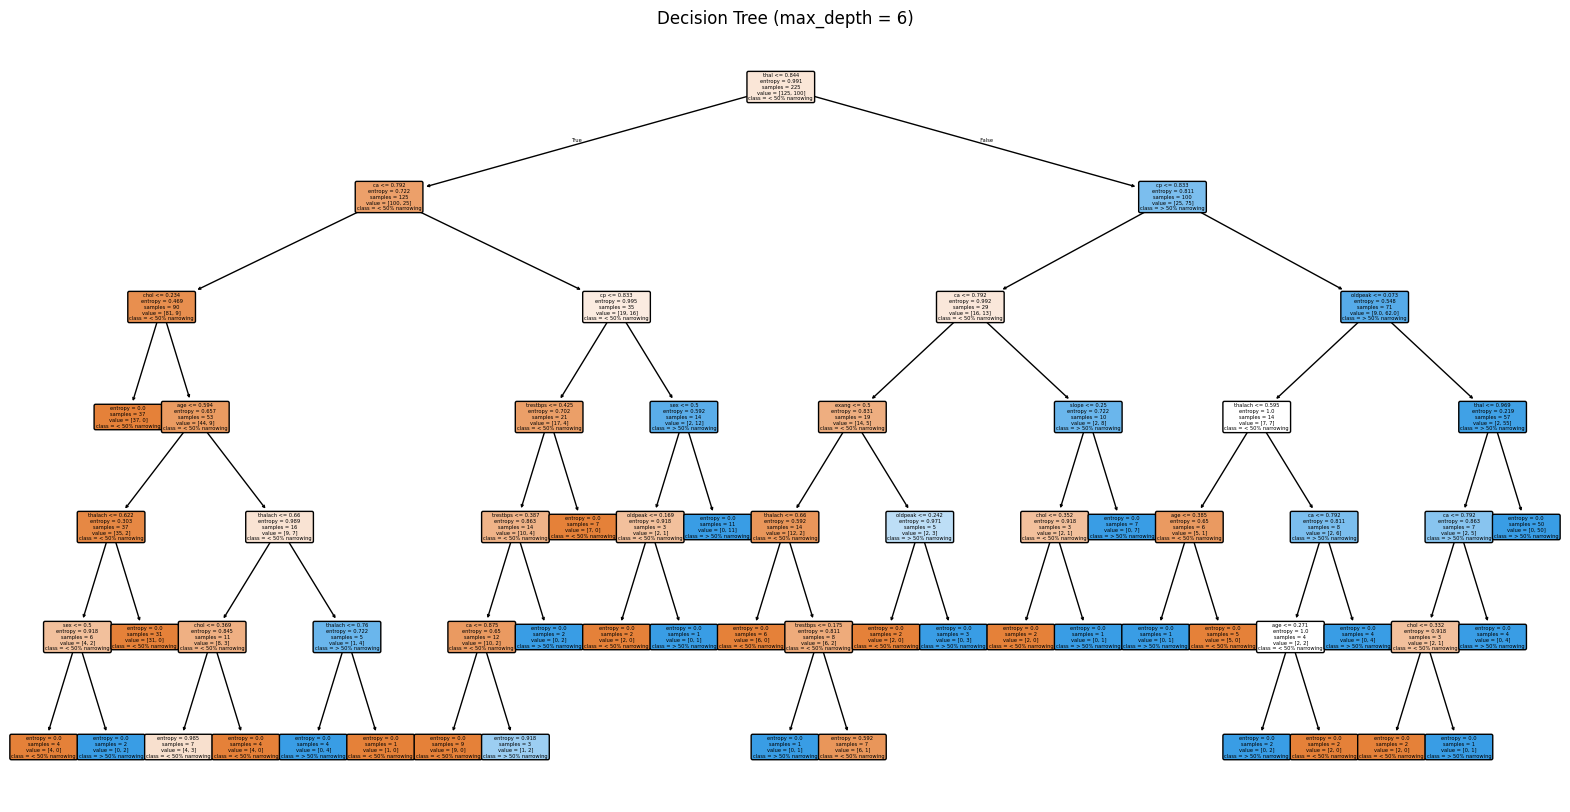


Classification Report for max_depth=6:
                 precision    recall  f1-score   support

< 50% narrowing       0.79      0.84      0.82        32
> 50% narrowing       0.78      0.72      0.75        25

       accuracy                           0.79        57
      macro avg       0.79      0.78      0.78        57
   weighted avg       0.79      0.79      0.79        57



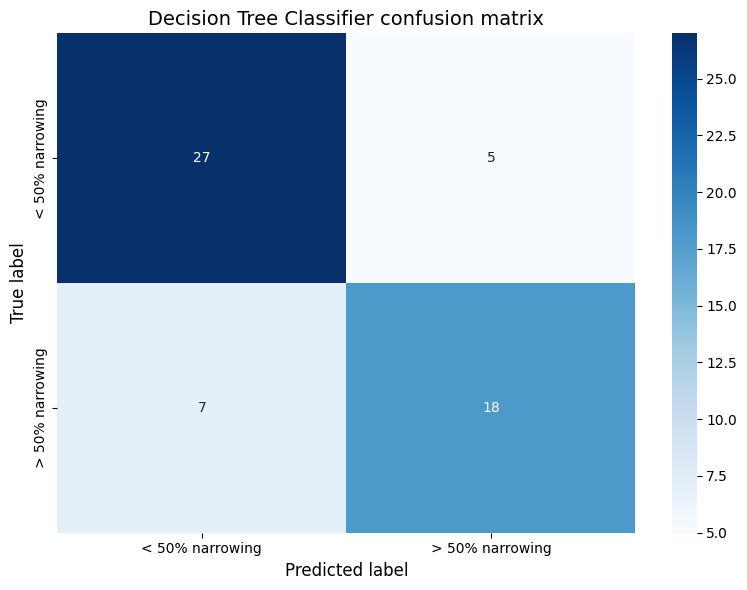

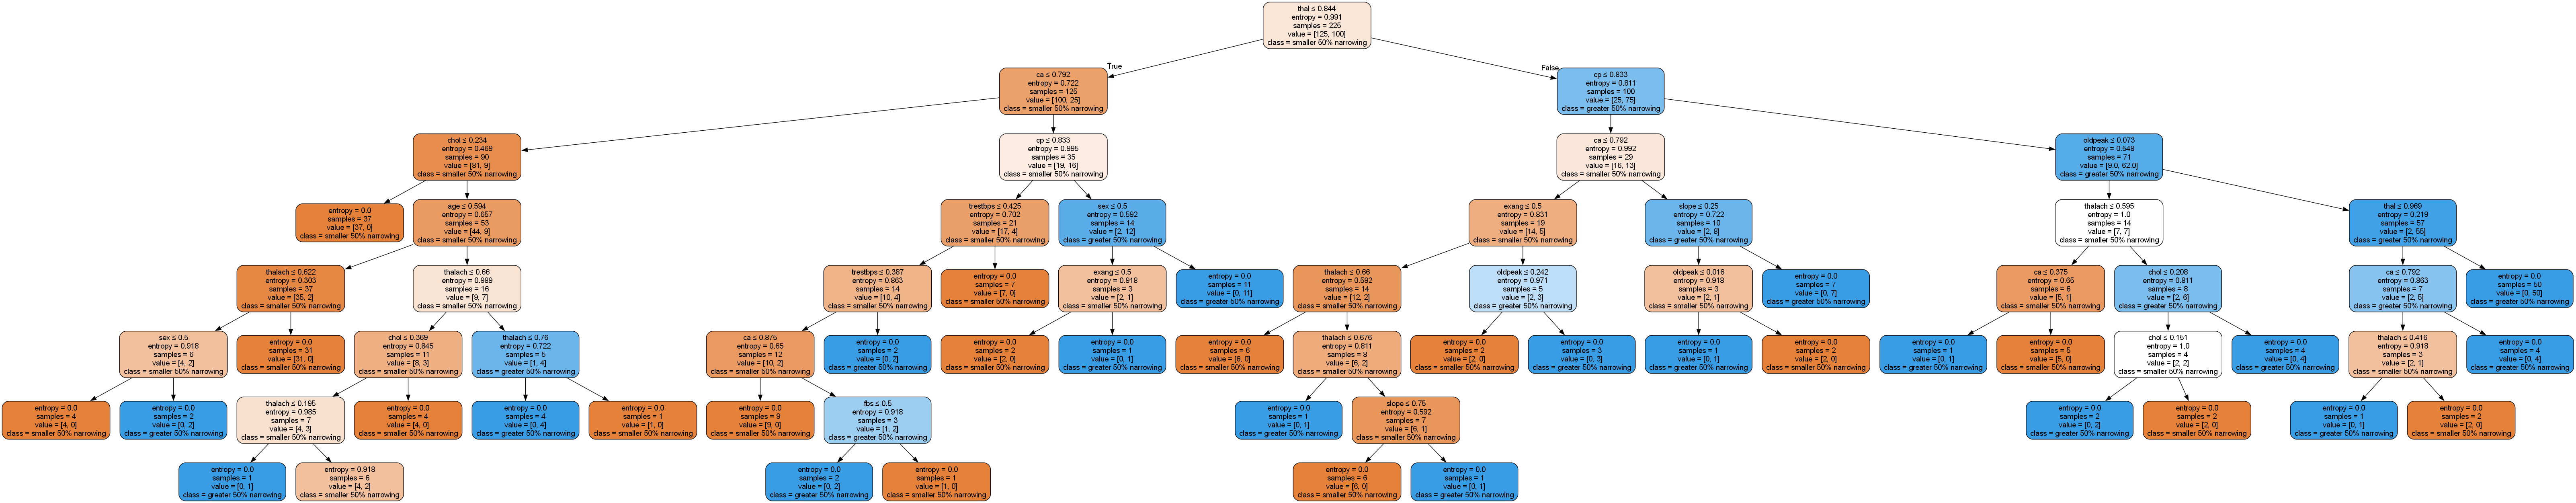

Saved decision tree as tree_depth_7_train_80.png


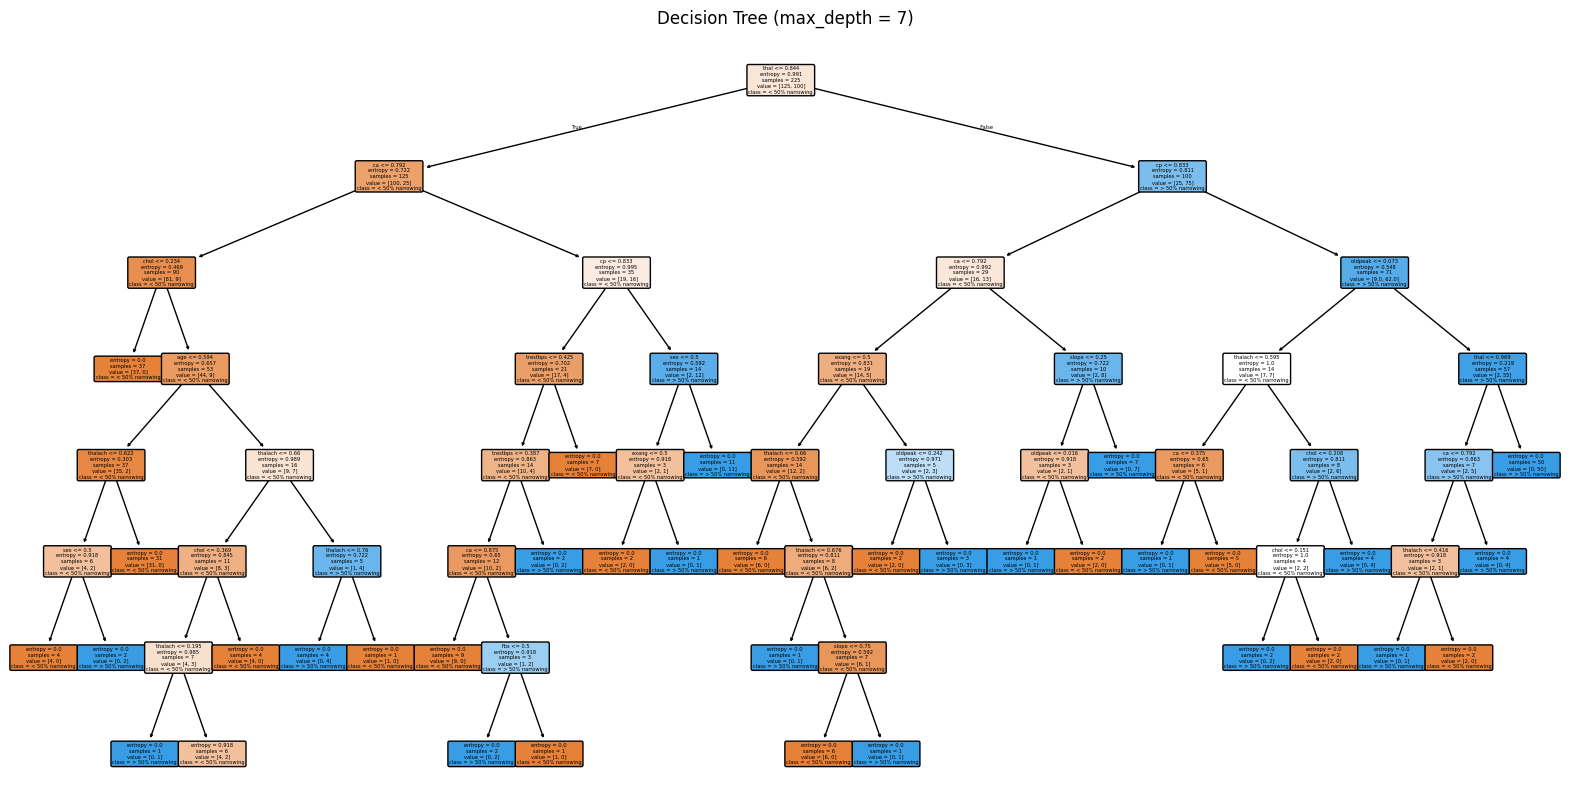


Classification Report for max_depth=7:
                 precision    recall  f1-score   support

< 50% narrowing       0.73      0.84      0.78        32
> 50% narrowing       0.75      0.60      0.67        25

       accuracy                           0.74        57
      macro avg       0.74      0.72      0.72        57
   weighted avg       0.74      0.74      0.73        57



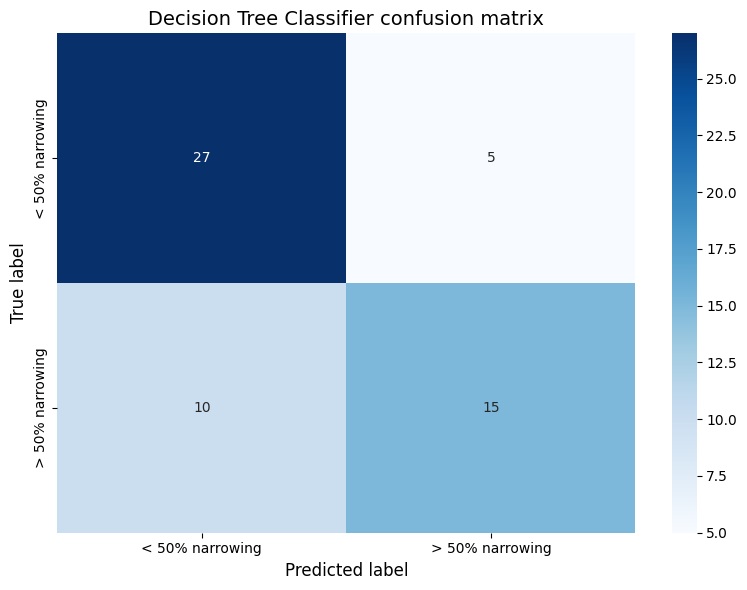


Accuracy for Different Decision Tree Depths:
max_depth  accuracy
Unlimited  0.736842
        2  0.684211
        3  0.736842
        4  0.771930
        5  0.684211
        6  0.789474
        7  0.736842


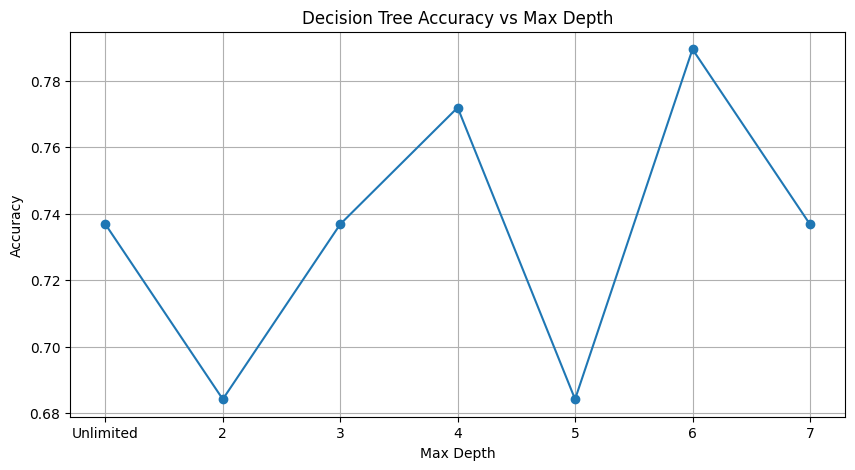

In [83]:

max_depths = [None, 2, 3, 4, 5, 6, 7]
depth_accuracy_results = evaluate_decision_tree_depths(X, y, max_depths)
